# Visualize SQL (PostgreSQL) Query Results with Matplotlib/Seaborn

In [95]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import text as sql_text
from urllib import parse
from math import ceil
import locale
import matplotlib.pyplot as plt
import matplotlib.colors as m_colors
from matplotlib.patches import Patch, FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
from matplotlib import colormaps
import seaborn as sns

In [96]:
# connect to postgres database

with open("C:/Users/Default/pstgr_pw.txt", "r") as f:
    DB_PASSWORD = parse.quote(f.read())
DB_USER = 'postgres'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'airline_data'

engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

In [97]:
# localized language/display settings

language_setting = "German" # settings: "English" (default) or "German"

def set_display_locale(lang):
    if lang == "English":
        locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
        def fmt(x_):
            if abs(x_) < 1000:
                return f"{x_:,.2f}"
            else:
                return f"{x_:,.0f}"
    elif lang == "German":
        locale.setlocale(locale.LC_ALL, "de_DE.UTF-8")
        def fmt(x_):
            if abs(x_) < 1000:
                return locale.format_string("%.2f", x_, grouping=True)
            else:
                return locale.format_string("%.0f", x_, grouping=True)
    else:
        raise ValueError("lang must be 'English' or 'German'")

    pd.options.display.float_format = fmt


set_display_locale(language_setting)
#pd.reset_option("display.float_format")

In [98]:
with open("../(ii)_summary_query.sql", "r", encoding="utf-8") as file:
    summary_query = file.read()

df_summary = pd.read_sql(summary_query, engine)

df_summary

,source_period,total_scheduled_flights,total_flight_cancellations,total_flights,total_bookings,total_passengers,avg_passengers_per_flight,avg_booked_rate_pct,avg_occupancy_rate_pct,total_revenue,total_cost,total_profit,avg_profit_margin_pct,avg_profit_per_flight,cancellation_rate_pct,on_time_arrival_rate_pct
0,2022–2024,289344,12174,277170,40.633.009,37410981,"134,97","77,49","74,26",13.207.461.874,11.082.684.123,2.124.777.751,"14,02",7.666,"4,21","65,02"


## Source Period Summary/Overview

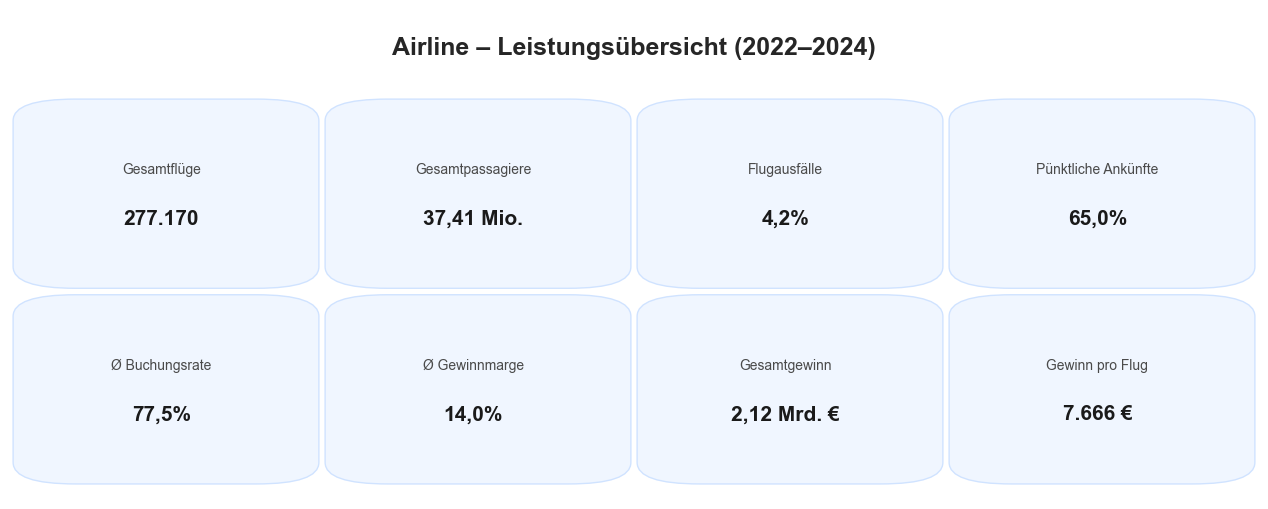

In [99]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

annotations_english = {
    "title": "Airline Performance Overview",
    "flights": "Total Flights", "passengers": "Total Passengers", "cxl_pct": "Flight Cancellations",
    "on_time_pct": "On-Time Arrivals", "avg_br_pct": "Avg Booked Rate", "avg_profit_pct": "Avg Profit Margin",
    "total_profit": "Total Profit", "avg_profit_flight": "Profit per Flight",
    "million": "M", "billion": "B", "file_name": "english/(01)_airline_summary.png"
}

annotations_german = {
    "title": "Airline – Leistungsübersicht",
    "flights": "Gesamtflüge", "passengers": "Gesamtpassagiere", "cxl_pct": "Flugausfälle",
    "on_time_pct": "Pünktliche Ankünfte", "avg_br_pct": "Ø Buchungsrate", "avg_profit_pct": "Ø Gewinnmarge",
    "total_profit": "Gesamtgewinn", "avg_profit_flight": "Gewinn pro Flug",
    "million": " Mio.", "billion": " Mrd.", "file_name": "german/(01)_airline_zusammenfassung.png"
}

annot = [annotations_german if language_setting == "German" else annotations_english][0]

kpis = {
    annot["flights"]: f"{df_summary.total_flights[0]}",
    annot["passengers"]: f"{df_summary.total_passengers[0]}",
    annot["cxl_pct"]: f"{df_summary.cancellation_rate_pct[0]}%",
    annot["on_time_pct"]: f"{df_summary.on_time_arrival_rate_pct[0]}%",
    annot["avg_br_pct"]: f"{df_summary.avg_booked_rate_pct[0]}%",
    annot["avg_profit_pct"]: f"{df_summary.avg_profit_margin_pct[0]}%",
    annot["total_profit"]: f"{df_summary.total_profit[0]} €",
    annot["avg_profit_flight"]: f"{df_summary.avg_profit_per_flight[0]} €"
}

# abbreviated and localized format for numeric KPIs
formatted_kpis = {}
for k, v in kpis.items():
    try:
        # Clean numeric content for parsing
        raw_val = float(str(v).replace("€", "").replace("%", "").replace(",", "").strip())

        # Abbreviation logic
        if abs(raw_val) >= 1_000_000_000:
            formatted_v = f"{raw_val / 1_000_000_000:.2f}"
            if language_setting == "German":
                formatted_v = formatted_v.replace(".", ",")
            formatted_v += annot["billion"]
            if "€" in v:
                formatted_v += " €"
        elif abs(raw_val) >= 1_000_000:
            formatted_v = f"{raw_val / 1_000_000:.2f}"
            if language_setting == "German":
                formatted_v = formatted_v.replace(".", ",")
            formatted_v += annot["million"]
            if "€" in v:
                formatted_v += " €"
        else:
            # For smaller numbers, use locale formatting
            if "€" in v:
                num = float(str(v).replace("€", "").strip())
                formatted_v = f"{locale.format_string('%.0f', num, grouping=True)} €"
            elif "%" in v:
                num = float(str(v).replace("%", "").strip())
                formatted_v = f"{locale.format_string('%.1f', num)}%"
            else:
                num = float(str(v).replace(",", "").strip())
                formatted_v = locale.format_string("%.0f", num, grouping=True)

        formatted_kpis[k] = formatted_v

    except ValueError:
        # Non-numeric, leave untouched
        formatted_kpis[k] = v

# plot
n = len(formatted_kpis)
n_cols = ceil(n / 2)
n_rows = 2
fig, ax = plt.subplots(figsize=(13, 5))
ax.axis("off")
plt.suptitle(f"\n{annot["title"]} ({df_summary.source_period[0]})", fontsize=18, fontweight="bold")

card_width = 1 / n_cols
card_height = 0.38
x_pad = 0.0325
y_pad = 0.075
y_start = 0.065

# coordinates for rows (top → bottom)
row_y_positions = [y_start + card_height + y_pad, y_start]

for i, (label, value) in enumerate(formatted_kpis.items()):
    row = i // n_cols
    col = i % n_cols
    x = col * card_width + x_pad
    y = row_y_positions[row]

    # card background
    card = FancyBboxPatch(
        (x, y), card_width - 0.065, card_height, boxstyle="round,pad=0.03,rounding_size=0.05",
        linewidth=1, facecolor="#f0f6ff", edgecolor="#d0e3ff"
    )
    ax.add_patch(card)

    # label (above)
    ax.text(
        x + (card_width - 0.0725) / 2, y + card_height * 0.65, label,
        fontsize=10, color="#4a4a4a", ha="center", va="center",
    )

    # value (below)
    ax.text(
        x + (card_width - 0.0725) / 2, y + card_height * 0.35, str(value),
        fontsize=15, fontweight="bold", ha="center", va="center", color="#1a1a1a",
    )

plt.subplots_adjust(left=0.02, right=0.98, top=0.86, bottom=0.0)
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

## Routes x Seasons

In [100]:
# get query result from sql script

with open("../(B)_capacity_demand_and_utilization/(b)_lf_combined_grouping_variables/(01)_lf_route_tiers_seasons.sql", "r", encoding="utf-8") as file:
    route_tiers_seasons = file.read()

df_lf_route_tiers_seasons = pd.read_sql_query(sql=sql_text(route_tiers_seasons), con=engine)

# exclude grand total to not overcrowd heatmap
hm_lf_route_tiers_seasons = df_lf_route_tiers_seasons.copy().query("route_performance_tier != 'GRAND TOTAL (ALL TIERS)'")
hm_lf_route_tiers_seasons

,route_performance_tier,route_tier_count,routes_tier_share,travel_season,avg_seat_capacity,avg_booking_count,avg_booked_rate,min_booked_rate,max_booked_rate,booked_rate_stddev,avg_passenger_count,avg_occupancy_rate,avg_check_in_gap
0,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(1) Jan & Feb,"237,84","193,30","80,71","65,91","98,11","3,06","186,34","77,74","3,00"
1,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(2) Spring,"238,65","214,02","89,09","73,06","98,96","3,04","208,49","86,74","2,34"
2,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(3) Summer,"238,72","227,74","95,04","80,00","98,96","1,84","222,92","93,02","2,00"
3,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(4) Autumn,"237,71","206,71","86,38","66,21","98,96","3,09","200,68","83,82","2,56"
4,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(5) December,"236,75","225,97","95,10","80,30","98,96","1,82","221,34","93,12","1,98"
5,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(ALL SEASONS),"237,94","213,55","89,26","65,91","98,96","6,06","207,95","86,89","2,38"
6,(B) Within Target|76-85% Overall Avg BR,76,"53,52",(1) Jan & Feb,"193,67","139,32","71,76","56,67","85,49","2,49","131,84","67,89","3,87"
7,(B) Within Target|76-85% Overall Avg BR,76,"53,52",(2) Spring,"193,34","153,15","79,00","64,02","95,24","2,83","147,16","75,89","3,11"
8,(B) Within Target|76-85% Overall Avg BR,76,"53,52",(3) Summer,"193,33","167,48","86,39","70,00","98,96","3,20","162,65","83,88","2,51"
9,(B) Within Target|76-85% Overall Avg BR,76,"53,52",(4) Autumn,"193,64","148,76","76,62","56,67","95,24","2,73","142,24","73,24","3,38"


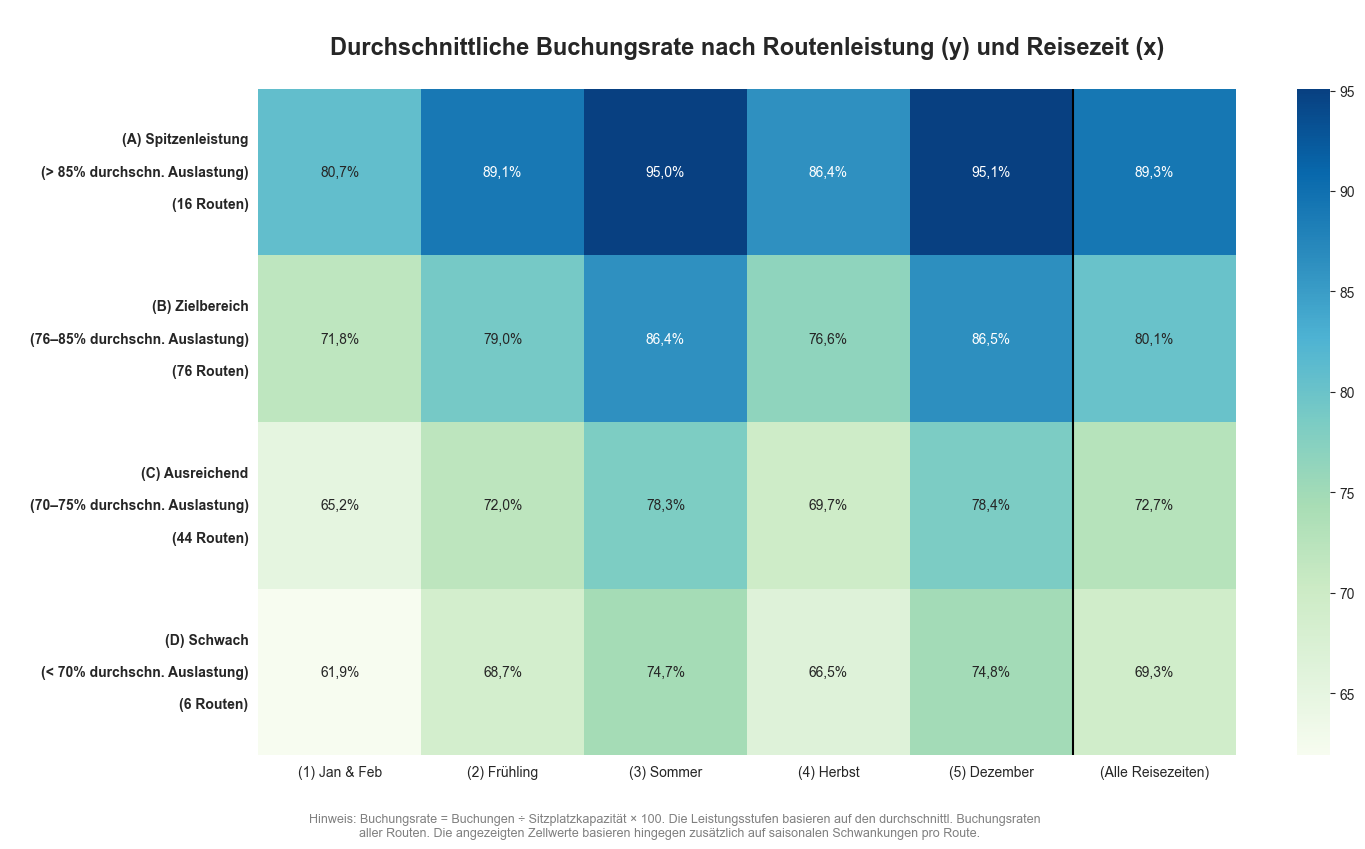

In [101]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale("German")

# provide translations, used when language_setting == "German"

tiers_eng = ["(A) Top Performance|> 85% Overall Avg BR", "(B) Within Target|76-85% Overall Avg BR",
             "(C) Sufficient|70-75% Overall Avg BR", "(D) Underperforming|< 70% Overall Avg BR"]
tiers_ger = ["(A) Spitzenleistung|> 85% durchschn. Auslastung", "(B) Zielbereich|76–85% durchschn. Auslastung",
             "(C) Ausreichend|70–75% durchschn. Auslastung", "(D) Schwach|< 70% durchschn. Auslastung"
]

seasons_eng = ["(1) Jan & Feb", "(2) Spring", "(3) Summer", "(4) Autumn", "(5) December", "(ALL SEASONS)"]
seasons_ger = ["(1) Jan & Feb", "(2) Frühling", "(3) Sommer", "(4) Herbst", "(5) Dezember", "(Alle Reisezeiten)"]

hm_lf_route_tiers_seasons["leistungsstufe"] = hm_lf_route_tiers_seasons["route_performance_tier"].replace(tiers_eng, tiers_ger)
hm_lf_route_tiers_seasons["reisezeit"] = hm_lf_route_tiers_seasons["travel_season"].replace(seasons_eng, seasons_ger)

annotations_english = {
    "title": "\nAvg Booked Rate by Route Performance Tier (y) and Travel Season (x)\n",
    "note": "Note: booked rate = bookings ÷ seat capacity * 100. The performance tiers are groupings "
            "based on avg booked rate across routes only, while the displayed booked rates reflect "
            "performance by both route and travel season.",
    "idx_hm": "route_performance_tier", "col_hm": "travel_season", "y_lbl_end": "Routes",
    "sep": "(ALL SEASONS)", "file_name": "english/(02a)_booked_rate_routes_seasons_heatmap.png"
}

annotations_german = {
    "title": "\nDurchschnittliche Buchungsrate nach Routenleistung (y) und Reisezeit (x)\n",
    "note": "    Hinweis: Buchungsrate = Buchungen ÷ Sitzplatzkapazität × 100. Die Leistungsstufen basieren "
          "auf den durchschnittl. Buchungsraten \naller Routen. Die angezeigten Zellwerte basieren hingegen "
          "zusätzlich auf saisonalen Schwankungen pro Route.",
    "idx_hm": "leistungsstufe", "col_hm": "reisezeit", "y_lbl_end": "Routen",
    "sep": "(Alle Reisezeiten)", "file_name": "german/(02a)_buchungsrate_routen_reisezeiten_heatmap.png"
}

# language switch
annot = [annotations_german if language_setting == "German" else annotations_english][0]

# pivot table for heatmap
heatmap_data = hm_lf_route_tiers_seasons.pivot(
    index=annot["idx_hm"], columns=annot["col_hm"], values="avg_booked_rate")

# localize cell label formats for annotations
cell_labels = heatmap_data.copy().map(
    lambda v_: locale.format_string("%.1f", v_, grouping=True) + "%" if pd.notna(v_) else ""
)

# prepare y-tick labels
route_tier_counts = (
    hm_lf_route_tiers_seasons[[annot["idx_hm"], "route_tier_count"]].drop_duplicates().set_index(annot["idx_hm"])
)

# plot
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, annot=cell_labels, fmt="", cmap="GnBu")

column_order = heatmap_data.columns.tolist()
separator_index = column_order.index(annot["sep"])
ax.vlines(separator_index, *ax.get_ylim(), colors='black', linewidth=1.5)

plt.title(annot["title"], size=17, fontweight="bold")
plt.xlabel("")
plt.ylabel(" ")

y_tick_locs = ax.get_yticks()

# clean y-tick label formats
y_labels = []
for tier in heatmap_data.index:
    part_1, part_2 = tier.split("|")
    y_labels.append(
        f"{part_1}\n\n({part_2})\n\n({route_tier_counts.loc[tier, "route_tier_count"]} {annot["y_lbl_end"]})")

ax.set_yticks(y_tick_locs)
ax.set_yticklabels(y_labels, rotation=0)

for label in ax.get_yticklabels():
    label.set_fontweight("bold")

# add footnote
plt.figtext(0.45, -0.05, annot["note"], wrap=True, horizontalalignment="center", fontsize=9, color="gray")

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

In [102]:
with open(
        "../(B)_capacity_demand_and_utilization/(b)_lf_combined_grouping_variables/(02)_lf_routes_seasons_multi_tier.sql", "r", encoding="utf-8") as file:
    routes_seasons_multi_tier = file.read()

df_lf_routes_seasons_multi_tier = pd.read_sql_query(sql=sql_text(routes_seasons_multi_tier), con=engine)

hm_lf_routes_seasons_multi_tier = df_lf_routes_seasons_multi_tier.query("global_route_performance_tier != 'GRAND TOTAL (ALL)'").copy()

hm_lf_routes_seasons_multi_tier

,global_route_performance_tier,travel_season,seasonal_performance_tier,route_count,avg_seat_capacity,avg_booking_count,avg_booked_rate,min_booked_rate,max_booked_rate,booked_rate_stddev,avg_passenger_count,avg_occupancy_rate,avg_check_in_gap
0,(A) Top Perf. Globally,(1) Jan & Feb,(a) Top Perf. in Season,2,"307,23","261,59","85,14","72,56","98,11","0,05","253,46","82,48","2,69"
1,(A) Top Perf. Globally,(1) Jan & Feb,(b) Within Target in Season,14,"227,93","183,55","80,08","65,91","98,11","2,71","176,76","77,06","3,05"
2,(A) Top Perf. Globally,(2) Spring,(a) Top Perf. in Season,16,"238,65","214,02","89,09","73,06","98,96","3,04","208,49","86,74","2,34"
3,(A) Top Perf. Globally,(3) Summer,(a) Top Perf. in Season,16,"238,72","227,74","95,04","80,00","98,96","1,84","222,92","93,02","2,00"
4,(A) Top Perf. Globally,(4) Autumn,(a) Top Perf. in Season,9,"281,96","250,34","88,79","69,63","98,96","1,70","243,49","86,37","2,41"
5,(A) Top Perf. Globally,(4) Autumn,(b) Within Target in Season,7,"180,82","150,61","83,27","66,21","98,96","0,12","145,63","80,53","2,74"
6,(A) Top Perf. Globally,(5) December,(a) Top Perf. in Season,16,"236,75","225,97","95,10","80,30","98,96","1,82","221,34","93,12","1,98"
7,(B) Within Target Globally,(1) Jan & Feb,(c) Sufficient in Season,54,"196,87","144,25","73,09","59,72","85,49","1,58","136,91","69,37","3,73"
8,(B) Within Target Globally,(1) Jan & Feb,(d) Weak Perf. in Season,22,"185,79","127,22","68,47","56,67","78,33","0,18","119,39","64,26","4,21"
9,(B) Within Target Globally,(2) Spring,(b) Within Target in Season,76,"193,34","153,15","79,00","64,02","95,24","2,83","147,16","75,89","3,11"


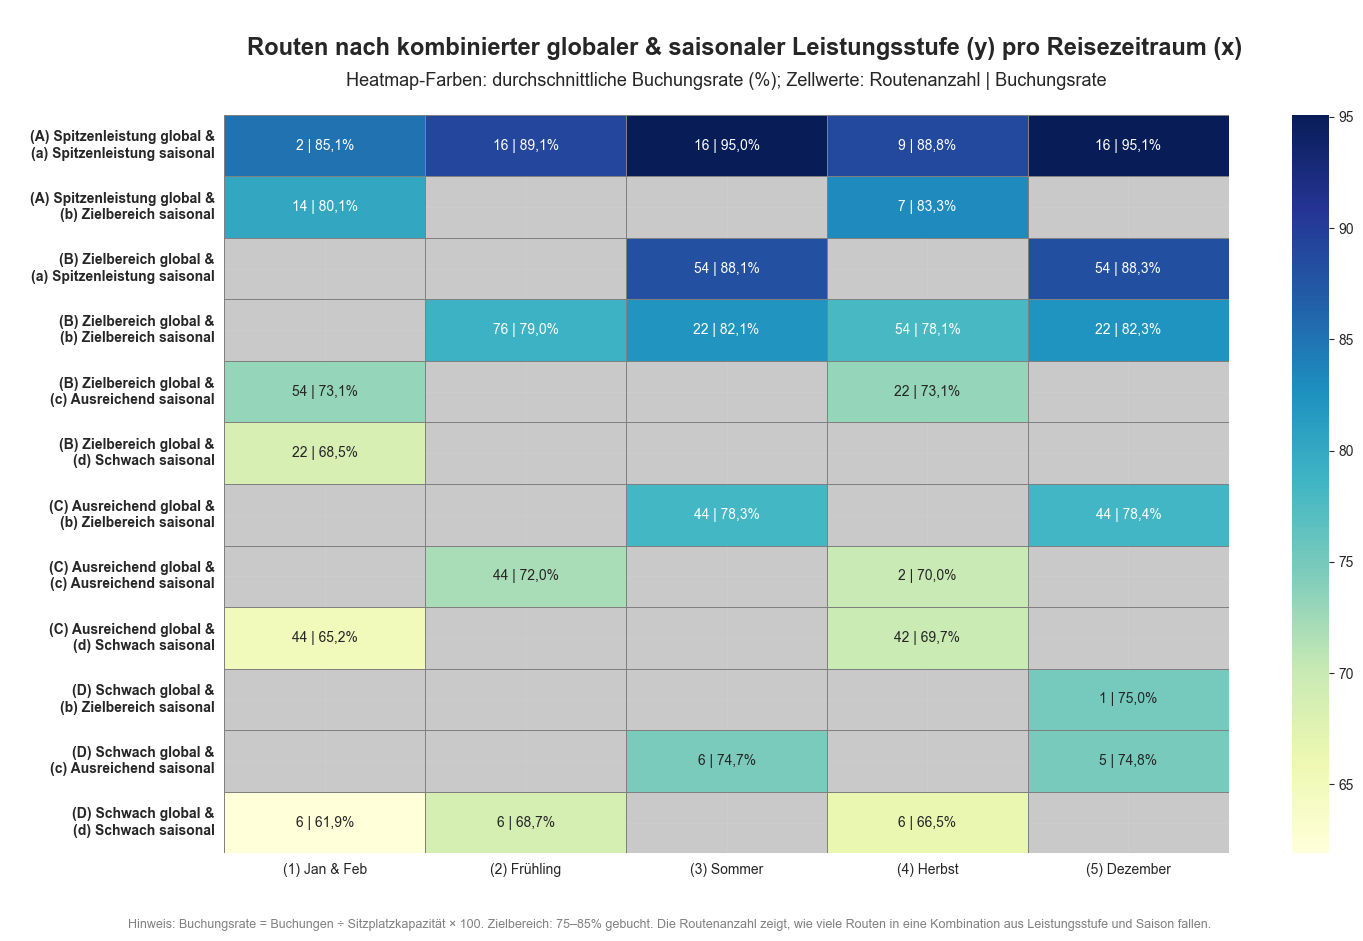

In [103]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

glob_tiers_eng = ["(A) Top Perf. Globally", "(B) Within Target Globally",
                  "(C) Sufficient Globally", "(D) Weak Perf. Globally"]
glob_tiers_ger = ["(A) Spitzenleistung global", "(B) Zielbereich global",
                  "(C) Ausreichend global", "(D) Schwach global"
]

season_tiers_eng = ["(a) Top Perf. in Season", "(b) Within Target in Season",
                    "(c) Sufficient in Season", "(d) Weak Perf. in Season"]
season_tiers_ger = ["(a) Spitzenleistung saisonal", "(b) Zielbereich saisonal",
                    "(c) Ausreichend saisonal", "(d) Schwach saisonal"]

seasons_eng = ["(1) Jan & Feb", "(2) Spring", "(3) Summer", "(4) Autumn", "(5) December"]
seasons_ger = ["(1) Jan & Feb", "(2) Frühling", "(3) Sommer", "(4) Herbst", "(5) Dezember"]

hm_lf_routes_seasons_multi_tier["leistungsstufe_global"] = (
    hm_lf_routes_seasons_multi_tier["global_route_performance_tier"].replace(glob_tiers_eng, glob_tiers_ger))
hm_lf_routes_seasons_multi_tier["reisezeit"] = (
    hm_lf_routes_seasons_multi_tier["travel_season"].replace(seasons_eng, seasons_ger))
hm_lf_routes_seasons_multi_tier["lestungsstufe_saisonal"] = (
    hm_lf_routes_seasons_multi_tier["seasonal_performance_tier"].replace(season_tiers_eng, season_tiers_ger))

annotations_english ={
    "title": "Heatmap colors: average booked rate (%); cell values: route count | average booked rate\n",
    "suptitle": "\nRoutes by Combined Global & Seasonal Performance Tier (y) per Travel Season (x)",
    "note": "Note: booked rate = bookings ÷ seat capacity * 100. Target performance: 75–85% booked. "
    "Counts show how many routes fall in each combined performance tier + season group.",
    "idx_hm": "combined_tier_label", "col_hm": "travel_season",
    "file_name": "english/(02b)_route_count_booked_rate_heatmap.png"
}

annotations_german = {
    "title": "Heatmap-Farben: durchschnittliche Buchungsrate (%); Zellwerte: Routenanzahl | Buchungsrate\n",
    "suptitle": "\nRouten nach kombinierter globaler & saisonaler Leistungsstufe (y) pro Reisezeitraum (x)",
    "note": "Hinweis: Buchungsrate = Buchungen ÷ Sitzplatzkapazität × 100. Zielbereich: 75–85% gebucht. "
            "Die Routenanzahl zeigt, wie viele Routen in eine Kombination aus Leistungsstufe und Saison fallen.",
    "idx_hm": "komb_stufen_label", "col_hm": "reisezeit",
    "file_name": "german/(02b)_routen_anzahl_buchungsrate_reisezeiten_heatmap.png"
}

hm_lf_routes_seasons_multi_tier["combined_tier_label"] = (
        hm_lf_routes_seasons_multi_tier["global_route_performance_tier"]
        + " &\n"
        + hm_lf_routes_seasons_multi_tier["seasonal_performance_tier"]
)

hm_lf_routes_seasons_multi_tier["komb_stufen_label"] = (
        hm_lf_routes_seasons_multi_tier["leistungsstufe_global"]
        + " &\n"
        + hm_lf_routes_seasons_multi_tier["lestungsstufe_saisonal"]
)

annot = [annotations_german if language_setting == "German" else annotations_english][0]

# pivot for annotation values
annotation_data = hm_lf_routes_seasons_multi_tier.pivot_table(
    index=annot["idx_hm"], columns=annot["col_hm"], values="route_count")

# pivot for heatmap color values
color_data = hm_lf_routes_seasons_multi_tier.pivot_table(
    index=annot["idx_hm"], columns=annot["col_hm"], values="avg_booked_rate")

# combine both into annotations, provide a localized and cleaned format

cell_labels = pd.DataFrame(index=annotation_data.index, columns=annotation_data.columns)

for row in cell_labels.index:
    for col in cell_labels.columns:
        count = annotation_data.at[row, col]
        rate = color_data.at[row, col]
        if pd.notnull(count) and pd.notnull(rate):
            formatted_rate = locale.format_string("%.1f", rate, grouping=False)
            cell_labels.at[row, col] = f"{int(count)} | {formatted_rate}%"
        else:
            cell_labels.at[row, col] = ""

# plot
fig, ax = plt.subplots(figsize=(15, 9))
ax.set_facecolor("#C9C9C9")
sns.heatmap(
    color_data,
    annot=cell_labels,
    fmt="",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    ax=ax
)

# titles and labels
ax.set_title(annot["title"], fontsize=13, y=1)
plt.suptitle(annot["suptitle"], fontsize=17, fontweight="bold")

plt.xlabel("")
plt.ylabel(" ")

# bold y labels
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

# footnote
plt.figtext(0.45, -0.04, annot["note"], wrap=True, horizontalalignment='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

In [104]:
# get query results from view
lf_tb_routes_seasons = "select * from lf_tb_routes_seasons"
df_lf_tb_routes_seasons = pd.read_sql(lf_tb_routes_seasons, engine)

tier_order = [
    'Top 2 – Jan & Feb',
    'Top 2 – Spring',
    'Top 2 – Summer',
    'Top 2 – Autumn',
    'Top 2 – December',
    'Bottom 2 – Jan & Feb',
    'Bottom 2 – Spring',
    'Bottom 2 – Summer',
    'Bottom 2 – Autumn',
    'Bottom 2 – December'
]

# enforce desired order
df_lf_tb_routes_seasons["route_per_travel_season_tier"] = (
    pd.Categorical(df_lf_tb_routes_seasons["route_per_travel_season_tier"], categories=tier_order, ordered=True)
)
df_lf_tb_routes_seasons

,route_per_travel_season_tier,travel_season,line_number,departure_location,arrival_location,booked_rank_desc,avg_booking_count,avg_booked_rate,min_booked_rate,max_booked_rate,avg_passenger_count,avg_occupancy_rate,avg_check_in_gap
0,Top 2 – Jan & Feb,(1) Jan & Feb,229,"FRA, Frankfurt, Germany","GRU, São Paulo, Brazil",1,"256,97","85,18","72,56","98,11","249,12","82,60","2,62"
1,Top 2 – Jan & Feb,(1) Jan & Feb,232,"FRA, Frankfurt, Germany","SYD, Sydney, Australia",2,"266,22","85,11","73,19","98,11","257,81","82,37","2,75"
2,Top 2 – Spring,(2) Spring,229,"FRA, Frankfurt, Germany","GRU, São Paulo, Brazil",1,"281,24","93,22","80,74","98,89","275,16","91,06","2,19"
3,Top 2 – Spring,(2) Spring,214,"DXB, Dubai, UAE","LHR, London, United Kingdom",2,"178,11","93,19","80,83","98,96","174,14","91,12","2,10"
4,Top 2 – Summer,(3) Summer,214,"DXB, Dubai, UAE","LHR, London, United Kingdom",1,"186,38","97,48","88,89","98,96","182,84","95,65","1,84"
5,Top 2 – Summer,(3) Summer,232,"FRA, Frankfurt, Germany","SYD, Sydney, Australia",2,"308,58","97,34","88,96","98,74","302,40","95,39","1,95"
6,Top 2 – Autumn,(4) Autumn,229,"FRA, Frankfurt, Germany","GRU, São Paulo, Brazil",1,"266,52","90,68","72,59","98,89","259,56","88,36","2,26"
7,Top 2 – Autumn,(4) Autumn,232,"FRA, Frankfurt, Germany","SYD, Sydney, Australia",2,"287,01","90,59","72,56","98,74","279,45","88,20","2,35"
8,Top 2 – December,(5) December,229,"FRA, Frankfurt, Germany","GRU, São Paulo, Brazil",1,"278,32","97,43","88,89","98,89","273,02","95,50","1,86"
9,Top 2 – December,(5) December,232,"FRA, Frankfurt, Germany","SYD, Sydney, Australia",2,"308,82","97,42","89,91","98,74","302,99","95,58","1,89"


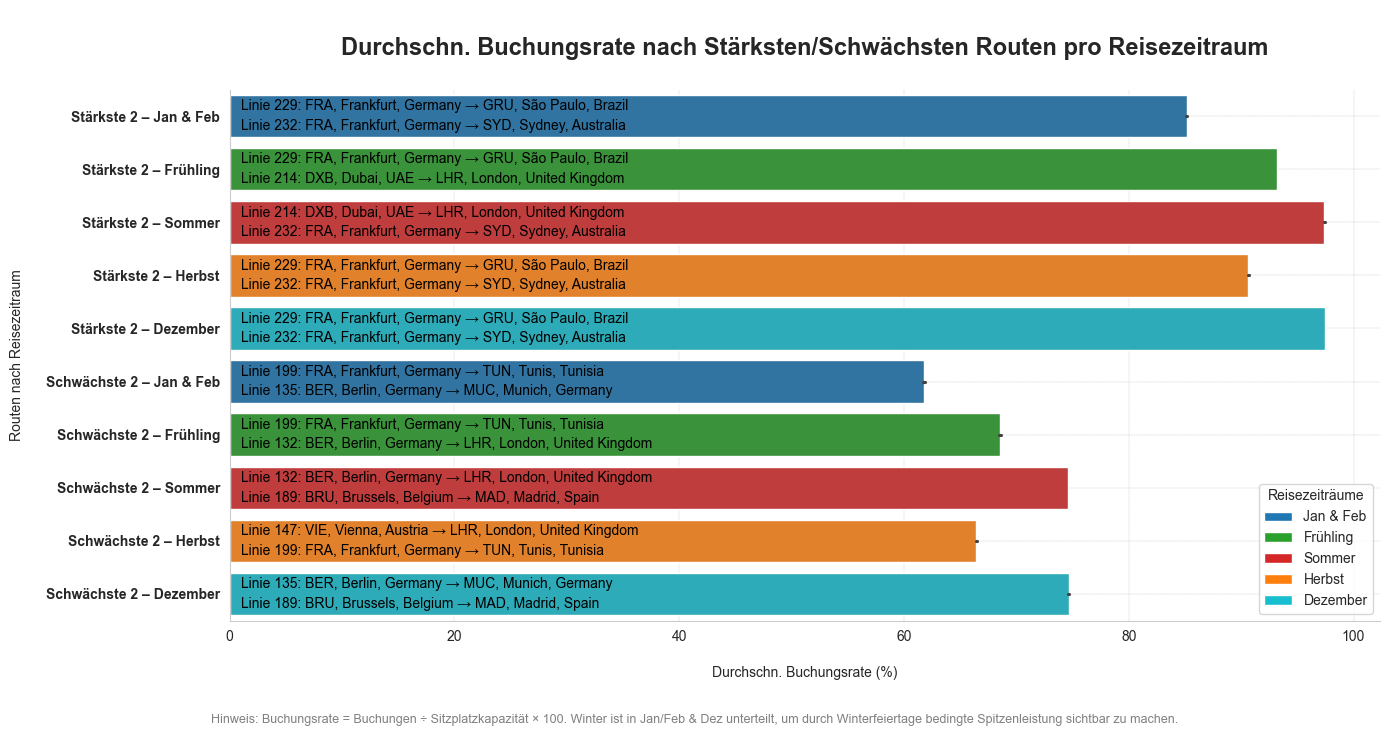

In [105]:
# overwrite global setting
#language_setting = "German"
#set_display_locale(language_setting)

# for this plot the translations will be inserted via conditionals and not via dictionaries
# due to the error-prone nature of label assignment based on categorical tier order

title = "\nDurchschn. Buchungsrate nach Stärksten/Schwächsten Routen pro Reisezeitraum\n" \
    if language_setting == "German" else "\nAverage Booked Rate by Top/Bottom Route per Season Group\n"
x_label = "\nDurchschn. Buchungsrate (%)" if language_setting == "German" else "\nAvg Booked Rate (%)"
y_label = "Routen nach Reisezeitraum\n" if language_setting == "German" else "Route per Season Group Tier\n"
legend_title = "Reisezeiträume" if language_setting == "German" else "Season Groups"
file_name = "german/(03)_buchungsrate_tf_routen_reisezeit.png" if language_setting == "German" \
    else "english/(03)_booked_rate_tb_routes_seasons.png"
line = "Linie" if language_setting == "German" else "Line"
note = ("Hinweis: Buchungsrate = Buchungen ÷ Sitzplatzkapazität × 100. Winter ist in Jan/Feb & Dez unterteilt, "
        "um durch Winterfeiertage bedingte Spitzenleistung sichtbar zu machen.") if language_setting == "German" else ("Note: "
        "booked rate = bookings ÷ seat capacity * 100. Winter is divided into Jan/Feb & Dec to make top performance caused by "
        "winter holidays visible.")

tier_display_map_ger = {
    "Top 2 – Jan & Feb": "Stärkste 2 – Jan & Feb",
    "Top 2 – Spring": "Stärkste 2 – Frühling",
    "Top 2 – Summer": "Stärkste 2 – Sommer",
    "Top 2 – Autumn": "Stärkste 2 – Herbst",
    "Top 2 – December": "Stärkste 2 – Dezember",
    "Bottom 2 – Jan & Feb": "Schwächste 2 – Jan & Feb",
    "Bottom 2 – Spring": "Schwächste 2 – Frühling",
    "Bottom 2 – Summer": "Schwächste 2 – Sommer",
    "Bottom 2 – Autumn": "Schwächste 2 – Herbst",
    "Bottom 2 – December": "Schwächste 2 – Dezember"
} if language_setting == "German" else {}

season_group_display_map_ger = {
    "(1) Jan & Feb": "Jan & Feb" if language_setting == "German" else "Jan & Feb",
    "(2) Spring": "Frühling" if language_setting == "German" else "Spring",
    "(3) Summer": "Sommer" if language_setting == "German" else "Summer",
    "(4) Autumn": "Herbst" if language_setting == "German" else "Autumn",
    "(5) December": "Dezember" if language_setting == "German" else "December",
}

# get and format route labels to display on top of bars
tier_route_names = {}
for tier in df_lf_tb_routes_seasons["route_per_travel_season_tier"].unique():
    routes = df_lf_tb_routes_seasons[df_lf_tb_routes_seasons["route_per_travel_season_tier"] == tier]
    route_labels = [
        f"{line} {row.line_number}: {row.departure_location} → {row.arrival_location}"
        for _, row in routes.iterrows()
    ]
    tier_route_names[tier] = route_labels

# define custom palette
palette = {
    "(1) Jan & Feb": "#1f77b4", # blue
    "(2) Spring": "#2ca02c",    # green
    "(3) Summer": "#d62728",    # red
    "(4) Autumn": "#ff7f0e",    # orange
    "(5) December": "#17becf"   # cyan/turquoise
}

# plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=df_lf_tb_routes_seasons,
    y="route_per_travel_season_tier",
    x="avg_booked_rate",
    hue="travel_season",
    orient="h",
    palette=palette,
    legend=False
)

ax.grid(color="grey", linestyle="--", linewidth=0.3, alpha=0.5)

# build mapping from y-tick positions to tier names
y_pos_to_tier = {
    round(label.get_position()[1], 2): label.get_text()
    for label in ax.get_yticklabels()
}

# annotate bars using the closest y-tick label
for bar in ax.patches:
    bar_y_center = bar.get_y() + bar.get_height() / 2
    closest_y = min(y_pos_to_tier.keys(), key=lambda y_: abs(bar_y_center - y_))
    tier = y_pos_to_tier[closest_y]

    if tier in tier_route_names:
        text = '\n'.join(tier_route_names[tier])
        ax.text(
            x=bar.get_x() + 1,
            y=bar_y_center,
            s=text,
            va='center',
            ha='left',
            fontsize=10,
            color='black',
            linespacing=1.5
        )

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([
    tier_display_map_ger.get(label.get_text(), label.get_text())
    for label in ax.get_yticklabels()
])

for label in ax.get_yticklabels():
    label.set_fontweight('bold')

plt.title(title, size=17, fontweight="bold")
plt.subplots_adjust(left=0.3)
plt.xlabel(x_label)
plt.ylabel(y_label)

# construct and place legend
legend_elements = [
    Patch(facecolor=color, label=season_group_display_map_ger[label])
    for label, color in palette.items()
]

plt.legend(
    handles=legend_elements,
    title=legend_title,
    loc="lower right"
)

# footnote
plt.figtext(0.5, -0.04, note, wrap=True, horizontalalignment="center", fontsize=9, color="gray")

sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.savefig(file_name, dpi=300, bbox_inches="tight")
plt.show()

## Routes x Weekdays

In [106]:
lf_route_tiers_weekdays = "select * from lf_route_tiers_weekdays"
df_lf_route_tiers_weekdays = pd.read_sql(lf_route_tiers_weekdays, engine)

df_lf_route_tiers_weekdays

,route_performance_tier,route_tier_count,routes_tier_share,weekday,avg_seat_capacity,avg_booking_count,avg_booked_rate,min_booked_rate,max_booked_rate,booked_rate_stddev,avg_passenger_count,avg_occupancy_rate,avg_check_in_gap
0,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(1) Monday,"238,15","215,13","89,77","73,02","98,96","2,95","208,83","87,08","2,68"
1,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(2) Tuesday,"238,16","195,32","81,44","65,91","98,15","3,15","188,65","78,60","2,85"
2,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(3) Wednesday,"238,30","215,44","89,83","73,02","98,96","2,95","210,23","87,63","2,20"
3,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(4) Thursday,"238,11","215,26","89,82","73,02","98,96","2,96","210,14","87,63","2,22"
4,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(5) Friday,"238,09","228,14","95,49","80,00","98,96","1,66","225,63","94,42","1,06"
5,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(6) Saturday,"238,07","195,78","81,65","66,21","98,15","3,19","189,06","78,79","2,86"
6,(A) Top Performance|> 85% Overall Avg BR,16,"11,27",(7) Sunday,"238,12","228,17","95,48","80,00","98,96","1,71","221,40","92,63","2,83"
7,(B) Within Target|76-85% Overall Avg BR,76,"53,52",(1) Monday,"193,49","154,44","79,60","64,02","95,24","2,88","147,92","76,22","3,41"
8,(B) Within Target|76-85% Overall Avg BR,76,"53,52",(2) Tuesday,"193,52","140,28","72,31","56,67","85,49","2,53","133,18","68,60","3,73"
9,(B) Within Target|76-85% Overall Avg BR,76,"53,52",(3) Wednesday,"193,47","154,49","79,63","64,02","95,24","2,90","148,78","76,68","2,98"


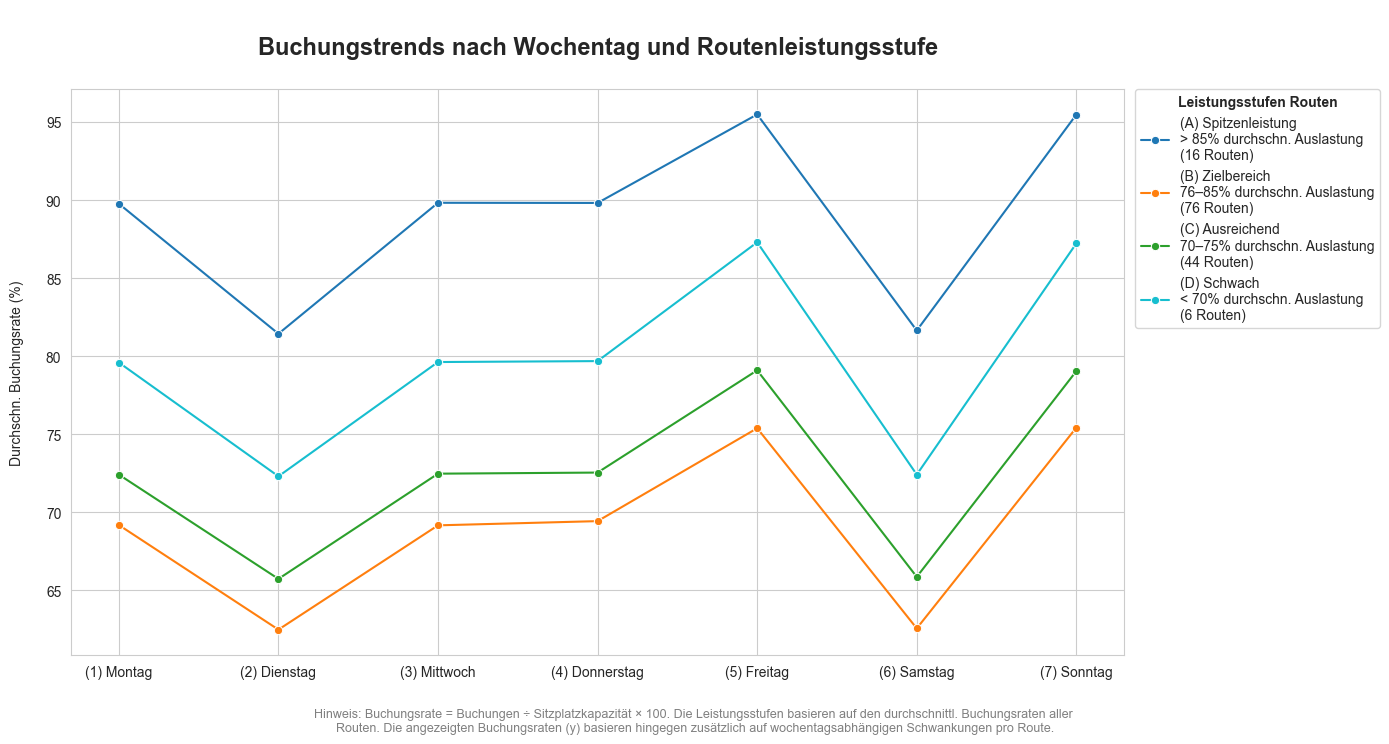

In [107]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

tiers_eng = ["(A) Top Performance|> 85% Overall Avg BR", "(B) Within Target|76-85% Overall Avg BR",
             "(C) Sufficient|70-75% Overall Avg BR", "(D) Underperforming|< 70% Overall Avg BR"]
tiers_ger = ["(A) Spitzenleistung|> 85% durchschn. Auslastung", "(B) Zielbereich|76–85% durchschn. Auslastung",
             "(C) Ausreichend|70–75% durchschn. Auslastung", "(D) Schwach|< 70% durchschn. Auslastung"
]

weekdays_eng = ["(1) Monday", "(2) Tuesday", "(3) Wednesday", "(4) Thursday", "(5) Friday", "(6) Saturday", "(7) Sunday"]
weekdays_ger = ["(1) Montag", "(2) Dienstag", "(3) Mittwoch", "(4) Donnerstag", "(5) Freitag", "(6) Samstag", "(7) Sonntag"]

df_lf_route_tiers_weekdays["leistungsstufe"] = df_lf_route_tiers_weekdays["route_performance_tier"].replace(tiers_eng, tiers_ger)
df_lf_route_tiers_weekdays["wochentag"] = df_lf_route_tiers_weekdays["weekday"].replace(weekdays_eng, weekdays_ger)

annotations_english ={
    "title": "\nWeekday Booking Trends by Route Performance Tier\n",
    "note": "Note: booked rate = bookings ÷ seat capacity * 100. The performance tiers are groupings "
            "based on avg booked rate across routes only, while the displayed booked rates reflect "
            "performance by both route and weekday.",
    "hue": "route_performance_tier", "col": "weekday", "y_lbl": "Avg Booked Rate (%)\n", "legend_lbl_end": "Routes",
    "legend_title": "Route Performance Tiers", "file_name": "english/(04)_booked_rate_routes_weekdays_lineplot.png"
}

annotations_german = {
    "title": "\nBuchungstrends nach Wochentag und Routenleistungsstufe\n",
    "note": "Hinweis: Buchungsrate = Buchungen ÷ Sitzplatzkapazität × 100. Die Leistungsstufen basieren "
          "auf den durchschnittl. Buchungsraten aller \nRouten. Die angezeigten Buchungsraten (y) basieren hingegen "
          "zusätzlich auf wochentagsabhängigen Schwankungen pro Route.",
    "hue": "leistungsstufe", "col": "wochentag", "y_lbl": "Durchschn. Buchungsrate (%)\n", "legend_lbl_end": "Routen",
    "legend_title": "Leistungsstufen Routen", "file_name": "german/(04)_buchungsrate_routen_wochentage_lineplot.png"
}

annot = [annotations_german if language_setting == "German" else annotations_english][0]

# get route tier counts to display in legend
route_tier_counts = (
    df_lf_route_tiers_weekdays[[annot["hue"], "route_tier_count"]]
    .drop_duplicates().set_index(annot["hue"])
)

# get values to base custom palette on
tiers = df_lf_route_tiers_weekdays[annot["hue"]].unique().tolist()

# blue, green, cyan/turquoise, orange, red
colors = ["#1f77b4", "#17becf", "#2ca02c", "#ff7f0e", "#d62728"]

palette = {}
for tier, color in zip(tiers, colors):
    palette[tier] = color

# plot
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=df_lf_route_tiers_weekdays.sort_values(annot["col"]),
    x=annot["col"],
    y="avg_booked_rate",
    hue=annot["hue"],
    marker="o",
    palette=palette,
)
plt.title(annot["title"], size=17, fontweight="bold")
plt.ylabel(annot["y_lbl"])
plt.xlabel("")

# construct and place legend
handles, labels = ax.get_legend_handles_labels()
custom_labels = []
for label in labels:
    part_1, part_2 = label.split("|")
    custom_labels.append(f"{part_1}\n{part_2}\n({route_tier_counts.loc[label, 'route_tier_count']} {annot["legend_lbl_end"]})")

bold_font = FontProperties(weight='bold')
plt.legend(handles=handles, labels=sorted(custom_labels), title=annot["legend_title"],
           title_fontproperties=bold_font, bbox_to_anchor=(1.004, 1.011))

# footnote
plt.figtext(0.5, -0.05, annot["note"],wrap=True, horizontalalignment="center", fontsize=9, color="gray")

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

In [108]:
lf_tb_routes_weekdays = "select * from lf_tb_routes_weekdays"
df_lf_tb_routes_weekdays = pd.read_sql(lf_tb_routes_weekdays, engine)

tier_order = [
    'Top 3 – Fri, Sun',
    'Top 3 – Mon, Wed, Thu',
    'Top 3 – Tue, Sat',
    'Bottom 3 – Fri, Sun',
    'Bottom 3 – Mon, Wed, Thu',
    'Bottom 3 – Tue, Sat',
]

# enforce tier order
df_lf_tb_routes_weekdays["route_per_weekday_group_tier"] = pd.Categorical(df_lf_tb_routes_weekdays["route_per_weekday_group_tier"],
                                                            categories=tier_order, ordered=True)

df_lf_tb_routes_weekdays

,route_per_weekday_group_tier,weekday_group,line_number,departure_location,arrival_location,booked_rank_desc,avg_booking_count,avg_booked_rate,min_booked_rate,max_booked_rate,avg_passenger_count,avg_occupancy_rate,avg_check_in_gap
0,"Top 3 – Fri, Sun",Fri/Sun,229,"FRA, Frankfurt, Germany","GRU, São Paulo, Brazil",1,"291,12","97,66","88,89","98,89","285,75","95,83","1,81"
1,"Top 3 – Fri, Sun",Fri/Sun,232,"FRA, Frankfurt, Germany","SYD, Sydney, Australia",2,"308,67","97,59","88,89","98,74","302,92","95,74","1,86"
2,"Top 3 – Fri, Sun",Fri/Sun,214,"DXB, Dubai, UAE","LHR, London, United Kingdom",3,"186,52","97,57","88,89","98,96","182,96","95,72","1,82"
3,"Top 3 – Mon, Wed, Thu",Mon/Wed/Thu,229,"FRA, Frankfurt, Germany","GRU, São Paulo, Brazil",1,"279,93","93,84","81,48","98,89","273,20","91,62","2,13"
4,"Top 3 – Mon, Wed, Thu",Mon/Wed/Thu,214,"DXB, Dubai, UAE","LHR, London, United Kingdom",2,"179,03","93,67","80,83","98,96","174,96","91,55","2,11"
5,"Top 3 – Mon, Wed, Thu",Mon/Wed/Thu,227,"FRA, Frankfurt, Germany","SIN, Singapore, Singapore",3,"295,54","93,67","80,74","98,89","288,84","91,53","2,15"
6,"Top 3 – Tue, Sat",Tue/Sat,214,"DXB, Dubai, UAE","LHR, London, United Kingdom",1,"164,57","86,10","72,54","97,93","159,77","83,59","2,47"
7,"Top 3 – Tue, Sat",Tue/Sat,232,"FRA, Frankfurt, Germany","SYD, Sydney, Australia",2,"272,01","86,07","72,56","98,11","264,01","83,54","2,54"
8,"Top 3 – Tue, Sat",Tue/Sat,229,"FRA, Frankfurt, Germany","GRU, São Paulo, Brazil",3,"256,55","85,96","72,56","98,15","248,96","83,43","2,53"
9,"Bottom 3 – Fri, Sun",Fri/Sun,143,"HAM, Hamburg, Germany","VIE, Vienna, Austria",140,"128,91","75,40","63,33","86,11","122,98","71,97","3,45"


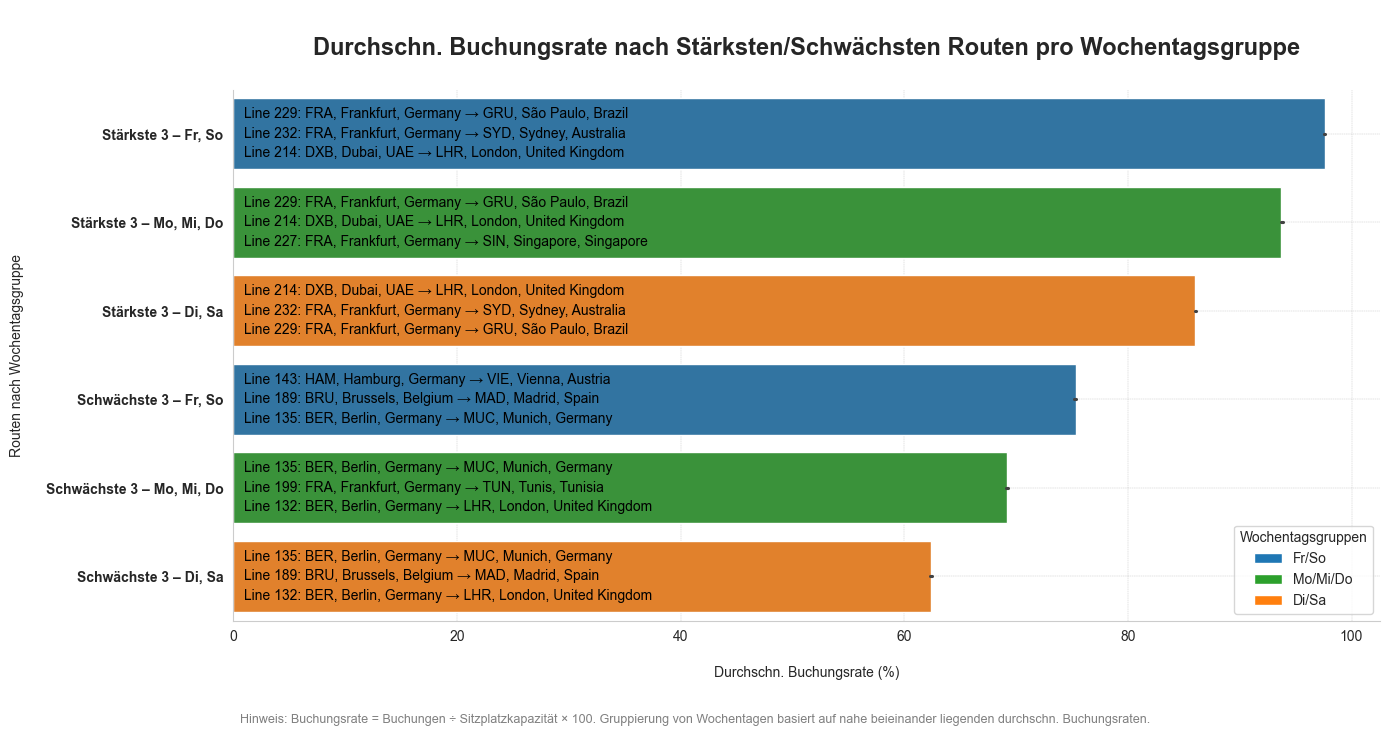

In [109]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

title = "\nDurchschn. Buchungsrate nach Stärksten/Schwächsten Routen pro Wochentagsgruppe\n" \
    if language_setting == "German" else "\nAverage Booked Rate by Top/Bottom Route per Weekday Group\n"
x_label = "\nDurchschn. Buchungsrate (%)" if language_setting == "German" else "\nAvg Booked Rate (%)"
y_label = "Routen nach Wochentagsgruppe\n" if language_setting == "German" else "Route per Weekday Group Tier\n"
legend_title = "Wochentagsgruppen" if language_setting == "German" else "Weekday Groups"
line = "Linie" if language_setting == "German" else "Line"
note = ("Hinweis: Buchungsrate = Buchungen ÷ Sitzplatzkapazität × 100. Gruppierung von Wochentagen basiert "
        "auf nahe beieinander liegenden durchschn. Buchungsraten.") if language_setting == "German" else ("Note: "
        "booked rate = bookings ÷ seat capacity * 100. Weekday grouping is based on proximity of related weekdays.")
file_name = "german/(05)_buchungsrate_tf_routen_wochentage.png" if language_setting == "German" \
    else "english/(05)_booked_rate_tb_routes_weekdays.png"

tier_display_map_ger = {
    "Top 3 – Fri, Sun": "Stärkste 3 – Fr, So",
    "Top 3 – Mon, Wed, Thu": "Stärkste 3 – Mo, Mi, Do",
    "Top 3 – Tue, Sat": "Stärkste 3 – Di, Sa",
    "Bottom 3 – Fri, Sun": "Schwächste 3 – Fr, So",
    "Bottom 3 – Mon, Wed, Thu": "Schwächste 3 – Mo, Mi, Do",
    "Bottom 3 – Tue, Sat": "Schwächste 3 – Di, Sa",
} if language_setting == "German" else {}

weekday_group_display_map_ger = {
    "Fri/Sun": "Fr/So" if language_setting == "German" else "Fri/Sun",
    "Mon/Wed/Thu": "Mo/Mi/Do" if language_setting == "German" else "Mon/Wed/Thu",
    "Tue/Sat": "Di/Sa" if language_setting == "German" else "Tue/Sat",
}

tier_route_names = {}
for tier in df_lf_tb_routes_weekdays["route_per_weekday_group_tier"].unique():
    routes = df_lf_tb_routes_weekdays[df_lf_tb_routes_weekdays["route_per_weekday_group_tier"] == tier]
    route_labels = [
        f"Line {row.line_number}: {row.departure_location} → {row.arrival_location}"
        for _, row in routes.iterrows()
    ]
    tier_route_names[tier] = route_labels

route_labels = [
        f"Line {row.line_number}: {row.departure_location} → {row.arrival_location}"
        for _, row in df_lf_tb_routes_weekdays.iterrows()
    ]

palette = {
    "Fri/Sun": "#1f77b4",        # blue
    "Mon/Wed/Thu": "#2ca02c",    # green
    "Tue/Sat": "#ff7f0e"         # orange
}

# plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=df_lf_tb_routes_weekdays,
    y="route_per_weekday_group_tier",
    x="avg_booked_rate",
    hue="weekday_group",
    orient="h",
    palette=palette,
    legend=False
)

ax.grid(color="grey", linestyle="--", linewidth=0.3, alpha=0.5)

# build mapping from y-tick positions to tier names
y_pos_to_tier = {
    round(label.get_position()[1], 2): label.get_text()
    for label in ax.get_yticklabels()
}

# annotate bars using the closest y-tick label
for bar in ax.patches:
    bar_y_center = bar.get_y() + bar.get_height() / 2
    closest_y = min(y_pos_to_tier.keys(), key=lambda y_: abs(bar_y_center - y_))
    tier = y_pos_to_tier[closest_y]

    if tier in tier_route_names:
        text = '\n'.join(tier_route_names[tier])
        ax.text(
            x=bar.get_x() + 1,
            y=bar_y_center,
            s=text,
            va='center',
            ha='left',
            fontsize=10,
            color='black',
            linespacing=1.5
        )

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([
    tier_display_map_ger.get(label.get_text(), label.get_text())
    for label in ax.get_yticklabels()
])

for label in ax.get_yticklabels():
    label.set_fontweight('bold')

plt.title(title, size=17, fontweight="bold")
plt.subplots_adjust(left=0.3)
plt.xlabel(x_label)
plt.ylabel(y_label)

# legend
legend_elements = [
    Patch(facecolor=color, label=weekday_group_display_map_ger[label])
    for label, color in palette.items()
]

plt.legend(
    handles=legend_elements,
    title=legend_title,
    loc="lower right"
)

# footnote
plt.figtext(0.5, -0.04, note, wrap=True, horizontalalignment="center", fontsize=9, color="gray")

sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.savefig(file_name, dpi=300, bbox_inches="tight")
plt.show()

## Routes x Passenger Classes

In [110]:
with open("../(B)_capacity_demand_and_utilization/(b)_lf_combined_grouping_variables/(07)_lf_route_class_tiers.sql", "r", encoding="utf-8") as file:
    lf_route_class_tiers = file.read()

df_lf_route_class_tiers = pd.read_sql_query(sql=sql_text(lf_route_class_tiers), con=engine)

hm_lf_route_class_tiers = df_lf_route_class_tiers.copy().query("passenger_class != '(GRAND TOTAL | ALL)'")

hm_lf_route_class_tiers

,passenger_class,booked_performance_tier,class_route_count,routes_share,avg_booking_capacity,avg_booking_count,avg_booked_rate,min_booked_rate,max_booked_rate,booked_rate_stddev,avg_occupancy_rate,avg_check_in_gap
0,(1) First,(A) Top Performance (> 85%),20,"6,58","15,52","13,97","90,02","41,18","100,00","0,28","87,80","2,23"
1,(2) Business,(A) Top Performance (> 85%),98,"32,24","28,46","24,49","85,67","35,71","100,00","1,09","83,13","2,54"
2,(2) Business,(B) Within Target (76-85%),44,"14,47","19,88","16,87","84,85","42,86","100,00","0,13","82,23","2,60"
3,(3) Economy,(A) Top Performance (> 85%),16,"5,26","188,48","169,35","89,43","61,14","100,00","2,98","87,04","2,39"
4,(3) Economy,(B) Within Target (76-85%),57,"18,75","165,34","132,91","80,31","50,21","100,00","2,23","77,30","3,05"
5,(3) Economy,(C) Sufficient (70-75%),63,"20,72","151,33","109,19","72,13","47,50","100,00","1,55","68,38","3,78"
6,(3) Economy,(D) Underperforming (< 70%),6,"1,97","150,23","101,21","67,45","46,15","87,65","0,21","63,36","4,16"
7,(ALL CLASSES),(A) Top Performance (> 85%),134,"44,08","45,63","40,22","86,76","35,71","100,00","2,28","84,29","2,48"
8,(ALL CLASSES),(B) Within Target (76-85%),101,"33,22","101,97","82,36","82,29","42,86","100,00","2,81","79,45","2,85"
9,(ALL CLASSES),(C) Sufficient (70-75%),63,"20,72","151,33","109,19","72,13","47,50","100,00","1,55","68,38","3,78"


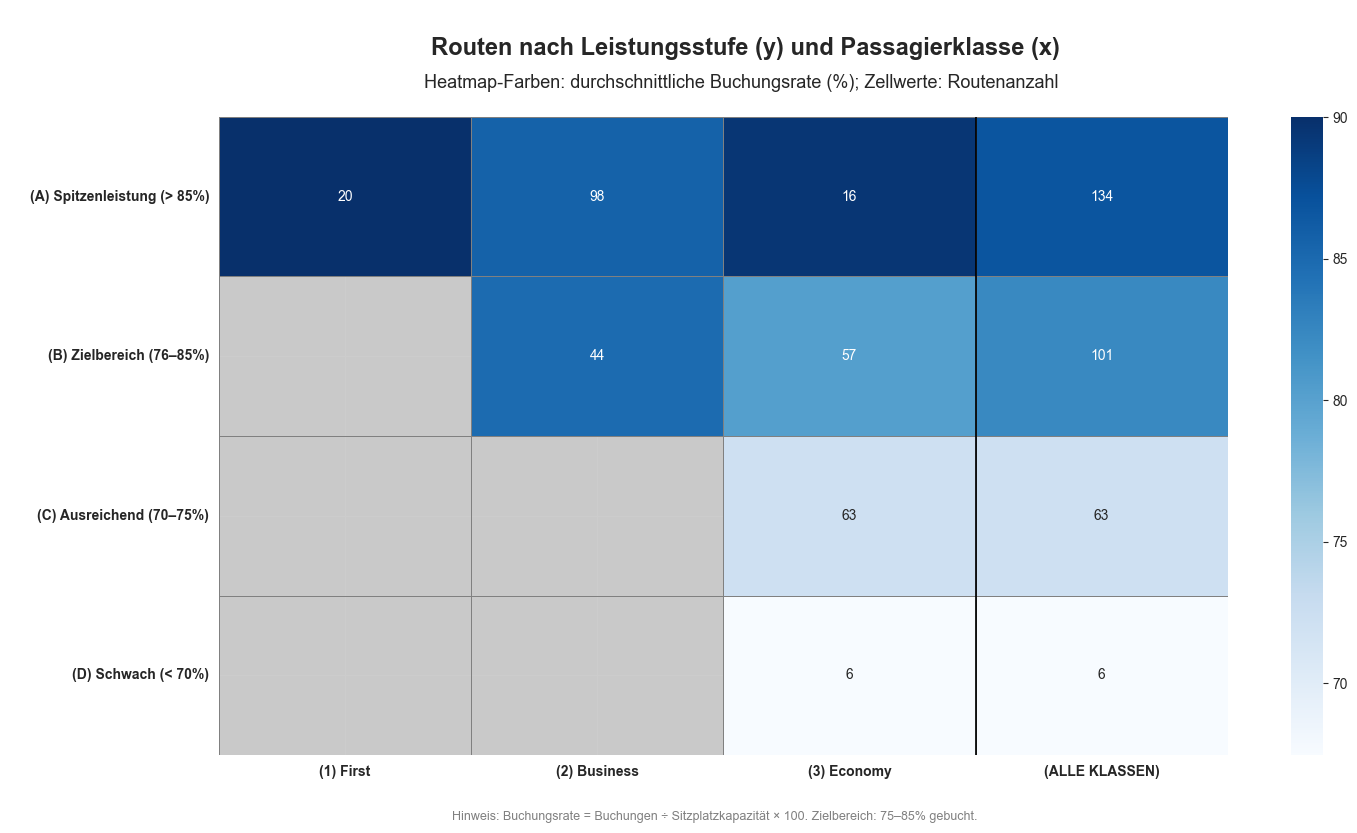

In [111]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

tiers_eng = ["(A) Top Performance (> 85%)", "(B) Within Target (76-85%)",
             "(C) Sufficient (70-75%)", "(D) Underperforming (< 70%)"]
tiers_ger = ["(A) Spitzenleistung (> 85%)", "(B) Zielbereich (76–85%)",
             "(C) Ausreichend (70–75%)", "(D) Schwach (< 70%)"
]

classes_eng = ["(1) First", "(2) Business", "(3) Economy", "(ALL CLASSES)"]
classes_ger = ["(1) First", "(2) Business", "(3) Economy", "(ALLE KLASSEN)"]

hm_lf_route_class_tiers["leistungsstufe"] = hm_lf_route_class_tiers["booked_performance_tier"].replace(tiers_eng, tiers_ger)
hm_lf_route_class_tiers["passagierklasse"] = hm_lf_route_class_tiers["passenger_class"].replace(classes_eng, classes_ger)

annotations_english ={
    "title": "      Heatmap colors: average booked rate (%); cell values: route count\n",
    "suptitle": "\nRoutes by Booked Performance Tier (y) and Passenger Class (x)",
    "note": "Note: booked rate = bookings ÷ seat capacity * 100; target performance: 75-85% booked.",
    "idx_hm": "booked_performance_tier", "col_hm": "passenger_class", "sep": "(ALL CLASSES)",
    "file_name": "english/(06)_route_classes_heatmap.png"
}

annotations_german = {
    "title": "       Heatmap-Farben: durchschnittliche Buchungsrate (%); Zellwerte: Routenanzahl\n",
    "suptitle": "\nRouten nach Leistungsstufe (y) und Passagierklasse (x)",
    "note": "Hinweis: Buchungsrate = Buchungen ÷ Sitzplatzkapazität × 100. Zielbereich: 75–85% gebucht.",
    "idx_hm": "leistungsstufe", "col_hm": "passagierklasse", "sep": "(ALLE KLASSEN)",
   "file_name": "german/(06)_routen_klassen_heatmap.png"
}

annot = [annotations_german if language_setting == "German" else annotations_english][0]

cell_label_data = hm_lf_route_class_tiers.pivot_table(
    index=annot["idx_hm"], columns=annot["col_hm"], values="class_route_count")
cell_labels = cell_label_data.copy().map(lambda v_: f"{int(v_)}" if pd.notnull(v_) else "")

color_data = hm_lf_route_class_tiers.pivot_table(
    index=annot["idx_hm"], columns=annot["col_hm"], values="avg_booked_rate")

# plot
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_facecolor("#C9C9C9")

sns.heatmap(color_data, annot=cell_labels, fmt="", cmap="Blues", linewidths=0.5, linecolor="gray", ax=ax)

column_order = cell_label_data.columns.tolist()
separator_index = column_order.index(annot["sep"])
ax.vlines(separator_index, *ax.get_ylim(), colors='black', linewidth=1.25)

ax.set_title(annot["title"], fontsize=13, y=1)
plt.suptitle(annot["suptitle"], fontsize=17, fontweight="bold")

ax.tick_params(axis="y", rotation=0)

plt.xlabel("")
plt.ylabel(" ")

for label in ax.get_yticklabels():
    label.set_fontweight('bold')
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# footnote
plt.figtext(0.48, -0.0325, annot["note"], wrap=True, horizontalalignment='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

## Route Profits

In [112]:
top_bottom_routes_profits = "select * from top_bottom_routes_profits"
df_tb_routes_profits = pd.read_sql(top_bottom_routes_profits, engine)
df_tb_routes_profits

,profitability_tier,line_number,route_name,distance_km,rank,pct_rank,avg_profit_margin,avg_booked_rate,avg_revenue,avg_cost,avg_profit,min_profit,max_profit,avg_profit_margin_all_routes,avg_profit_all_routes
0,"(A) Profit Margin (%), Rank 001",133,133: BER → HAM,274,1,"0,00","25,07","82,62",5.497,4.057,1.440,"-464,66",3.558,"14,16",10.537
1,"(A) Profit Margin (%), Rank 002",186,186: BRU → FRA,304,2,"0,71","25,01","82,57",5.891,4.353,1.538,"-601,39",4.735,"14,16",10.537
2,"(A) Profit Margin (%), Rank 141",132,132: BER → LHR,961,141,"99,29","3,70","69,07",13.327,12.694,"632,83",-2.241,7.581,"14,16",10.537
3,"(A) Profit Margin (%), Rank 142",199,199: FRA → TUN,1472,142,"100,00","3,66","69,09",36.068,34.365,1.703,-4.801,17.628,"14,16",10.537
4,"(B) Avg Profit, Rank 001",232,232: FRA → SYD,16496,1,"0,00","23,18","92,61",538.898,411.591,127.307,4.694,201.655,"14,16",10.537
5,"(B) Avg Profit, Rank 002",227,227: FRA → SIN,10278,2,"0,71","23,11","92,54",386.041,295.015,91.026,3.940,144.196,"14,16",10.537
6,"(B) Avg Profit, Rank 141",173,173: CDG → BRU,252,141,"99,29","9,71","72,61",3.951,3.521,"430,19","-561,70",1.989,"14,16",10.537
7,"(B) Avg Profit, Rank 142",135,135: BER → MUC,463,142,"100,00","3,98","69,05",6.100,5.803,"297,23",-1.274,3.453,"14,16",10.537


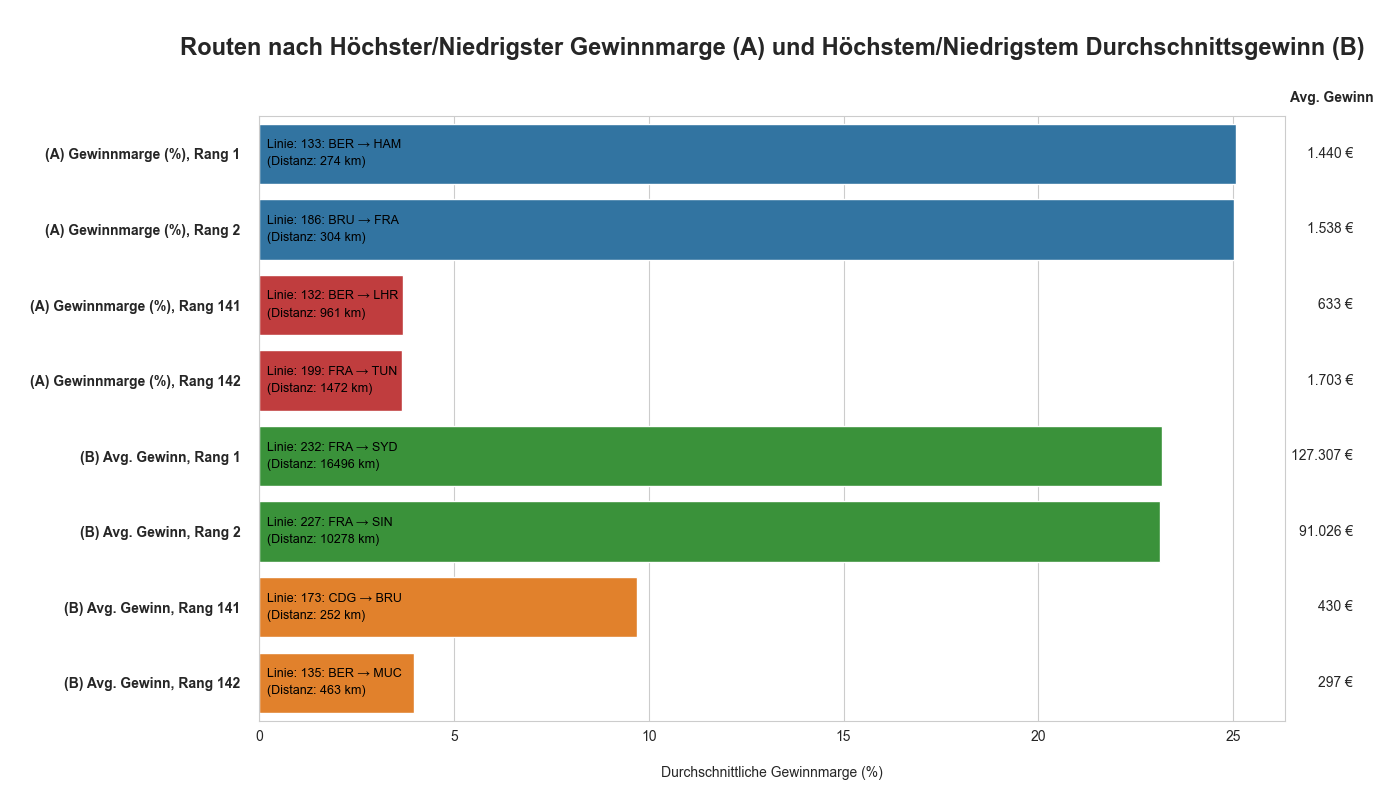

In [113]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

tiers_eng = [
    "(A) Profit Margin (%), Rank 001", "(A) Profit Margin (%), Rank 002",
    "(A) Profit Margin (%), Rank 141", "(A) Profit Margin (%), Rank 142",
    "(B) Avg Profit, Rank 001", "(B) Avg Profit, Rank 002",
    "(B) Avg Profit, Rank 141", "(B) Avg Profit, Rank 142"]

tiers_ger = [
    "(A) Gewinnmarge (%), Rang 001", "(A) Gewinnmarge (%), Rang 002",
    "(A) Gewinnmarge (%), Rang 141", "(A) Gewinnmarge (%), Rang 142",
    "(B) Avg. Gewinn, Rang 001", "(B) Avg. Gewinn, Rang 002",
    "(B) Avg. Gewinn, Rang 141", "(B) Avg. Gewinn, Rang 142"
]

df_tb_routes_profits["profitabilitätsstufe"] = df_tb_routes_profits["profitability_tier"].replace(tiers_eng, tiers_ger)

annotations_english = {
    "title": "\nRoutes by Top/Bottom Profit Margin (A) and Top/Bottom Avg Profit (B)\n\n",
    "y": "profitability_tier", "tiers": tiers_eng, "x_label": "\nAvg Profit Margin (%)", "distance": "Distance",
    "sec_y": "Avg Profit  ", "line": "Line", "file_name": "english/(07)_top_bottom_routes_profits.png"
}

annotations_german = {
    "title": "\nRouten nach Höchster/Niedrigster Gewinnmarge (A) und Höchstem/Niedrigstem Durchschnittsgewinn (B)\n\n",
    "y": "profitabilitätsstufe", "tiers": tiers_ger, "x_label": "\nDurchschnittliche Gewinnmarge (%)",
    "distance": "Distanz", "sec_y": "Avg. Gewinn ", "line": "Linie", "file_name": "german/(07)_tf_routen_profit.png"
}

annot = [annotations_german if language_setting == "German" else annotations_english][0]

# custom palette with fixed color per tier
conditions = [
    df_tb_routes_profits[annot["y"]].isin([annot["tiers"][0], annot["tiers"][1]]),
    df_tb_routes_profits[annot["y"]].isin([annot["tiers"][2], annot["tiers"][3]]),
    df_tb_routes_profits[annot["y"]].isin([annot["tiers"][4], annot["tiers"][5]]),
    df_tb_routes_profits[annot["y"]].isin([annot["tiers"][6], annot["tiers"][7]])
]
choices = ["Blue", "Red", "Green", "Orange"]
df_tb_routes_profits["color"] = np.select(conditions, choices, default="Gray")

palette = {
    "Blue": "#1f77b4",
    "Red": "#d62728",
    "Green": "#2ca02c",
    "Orange": "#ff7f0e",
    "Gray": "#C9C9C9"
}

# plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_tb_routes_profits,
    y=annot["y"],
    x="avg_profit_margin",
    hue="color",
    orient="h",
    palette=palette,
    legend=False
)

# display route names on top of bars
for bar, name, distance in zip(ax.patches, df_tb_routes_profits["route_name"], df_tb_routes_profits["distance_km"]):
    text = f"{annot["line"]}: {name}\n({annot["distance"]}: {distance} km)"
    bar_x = bar.get_x() + 9.2
    bar_y = bar.get_y()
    bar_width = bar.get_width()
    bar_height = bar.get_height()
    ax.text(
        x=bar_x - 9.0,
        y=bar_y + bar_height / 2,
        s=text,
        va='center',
        ha='left',
        fontsize=9,
        color='black',
        linespacing=1.5
    )

# display avg profits to the right of the bars
for bar, profit in zip(ax.patches, df_tb_routes_profits["avg_profit"]):
    bar_y = bar.get_y()
    bar_height = bar.get_height()
    ax.text(
        x=df_tb_routes_profits["avg_profit_margin"].max() + 3,
        y=bar_y + bar_height / 2,
        s=f"{locale.format_string('%.0f', profit, grouping=True)} €",
        va="center",
        ha="right",
        fontsize=10,
    )

ax.text(
    x=df_tb_routes_profits["avg_profit_margin"].max() + 2.5,
    y=-0.65,
    s=annot["sec_y"],
    ha='center',
    va='bottom',
    fontsize=10,
    fontweight='bold',
)

ax.yaxis.set_tick_params(pad=10)

cleaned_labels = [label.get_text().replace("00", "") for label in ax.get_yticklabels()]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(cleaned_labels, fontweight='bold')

plt.title(annot["title"], size=17, fontweight="bold")
plt.xlabel(annot["x_label"])
plt.ylabel(" ")

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

## General Operations

In [114]:
with open("../(D)_operational_performance/(05)_aircraft_turnaround_times.sql", "r", encoding="utf-8") as file:
    ac_turnaround = file.read()

df_ac_turnaround = pd.read_sql_query(sql=sql_text(ac_turnaround), con=engine)

df_ac_turnaround = df_ac_turnaround.query("incoming_flight_seat_capacity != 'GRAND TOTAL (ALL)'")

df_ac_turnaround

,incoming_flight_seat_capacity,incoming_flight_distance,flight_count,avg_turnaround_minutes,min_turnaround_minutes,max_turnaround_minutes,turnaround_minutes_stddev,turnaround_minutes_p25,turnaround_minutes_p75
0,(1) Seat Capacity < 120,(A) Distance < 800 km,7021,"36,51","32,00","41,00","2,89","34,00","39,00"
1,(1) Seat Capacity < 120,(B) Distance b/w 800 & 3000 km,7943,"41,45","37,00","46,00","2,88","39,00","44,00"
2,(2) Seat Capacity b/w 120 & 169,(A) Distance < 800 km,27158,"41,52","37,00","46,00","2,89","39,00","44,00"
3,(2) Seat Capacity b/w 120 & 169,(B) Distance b/w 800 & 3000 km,31199,"46,50","42,00","51,00","2,88","44,00","49,00"
4,(2) Seat Capacity b/w 120 & 169,(C) Distance b/w 3001 & 8000 km,1,"53,00","53,00","53,00",NaN,"53,00","53,00"
5,(3) Seat Capacity b/w 170 & 219,(A) Distance < 800 km,39283,"46,47","42,00","51,00","2,86","44,00","49,00"
6,(3) Seat Capacity b/w 170 & 219,(B) Distance b/w 800 & 3000 km,55233,"51,49","47,00","56,00","2,86","49,00","54,00"
7,(3) Seat Capacity b/w 170 & 219,(C) Distance b/w 3001 & 8000 km,20715,"56,50","52,00","61,00","2,88","54,00","59,00"
8,(4) Seat Capacity b/w 220 & 299,(C) Distance b/w 3001 & 8000 km,2107,"61,45","57,00","66,00","2,88","59,00","64,00"
9,(4) Seat Capacity b/w 220 & 299,(D) Distance > 8000 km,2999,"66,53","62,00","71,00","2,92","64,00","69,00"


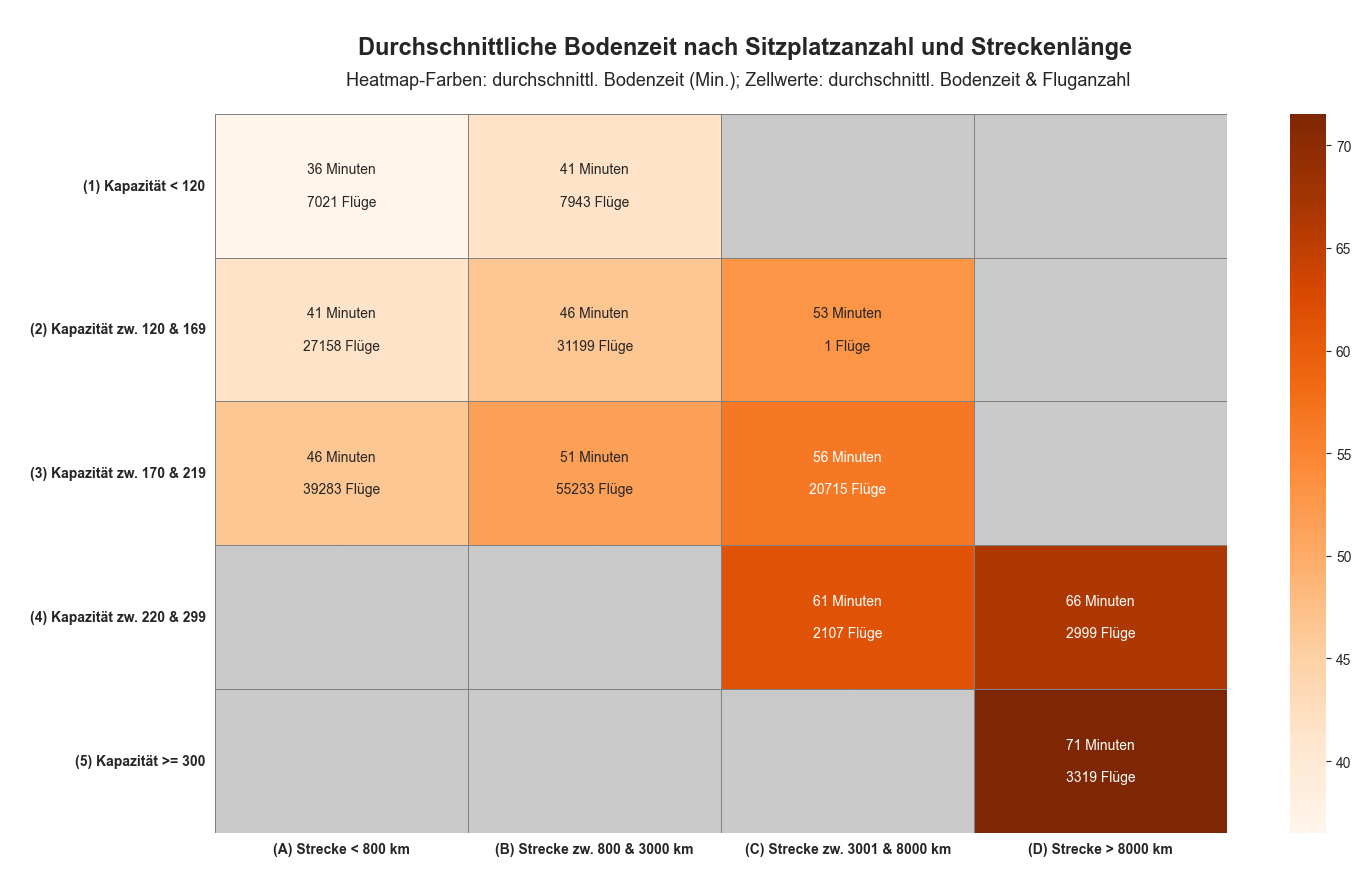

In [115]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

df_ac_turnaround["kapazitaet"] = (
    df_ac_turnaround["incoming_flight_seat_capacity"]
        .str.replace("Seat Capacity", "Kapazität")
        .str.replace("b/w", "zw.")
)

df_ac_turnaround["distanz"] = (
    df_ac_turnaround["incoming_flight_distance"]
        .str.replace("Distance", "Strecke")
        .str.replace("b/w", "zw.")
)

annotations_english ={
    "title": "   Heatmap colors: avg turnaround time (min); cell values: avg turnaround time & flight count\n",
    "suptitle": "\nAverage Aircraft Turnaround Time by Seat Capacity and Route Distance",
    "idx_hm": "incoming_flight_seat_capacity", "col_hm": "incoming_flight_distance", "mins": "Minutes",
    "flights": "Flights", "file_name": "english/(08)_ac_turnaround_heatmap.png"
}

annotations_german = {
    "title": "       Heatmap-Farben: durchschnittl. Bodenzeit (Min.); Zellwerte: durchschnittl. Bodenzeit & Fluganzahl\n",
    "suptitle": "\nDurchschnittliche Bodenzeit nach Sitzplatzanzahl und Streckenlänge",
    "idx_hm": "kapazitaet", "col_hm": "distanz", "mins": "Minuten",
    "flights": "Flüge", "file_name": "german/(08)_bodenzeit_heatmap.png"
}

annot = [annotations_german if language_setting == "German" else annotations_english][0]

# construct and format combined cell labels

avg_data = df_ac_turnaround.pivot_table(index=annot["idx_hm"], columns=annot["col_hm"], values="avg_turnaround_minutes")
count_data = df_ac_turnaround.pivot_table(index=annot["idx_hm"], columns=annot["col_hm"], values="flight_count")

cell_labels = pd.DataFrame(index=avg_data.index, columns=avg_data.columns)

for i in avg_data.index:
    for j in avg_data.columns:
        avg = avg_data.at[i, j]
        count = count_data.at[i, j]
        if pd.notnull(avg) and pd.notnull(count):
            cell_labels.at[i, j] = f"{int(avg)} {annot["mins"]}\n\n{int(count)} {annot["flights"]}"
        else:
            cell_labels.at[i, j] = ""

fig, ax = plt.subplots(figsize=(15, 9))
ax.set_facecolor("#C9C9C9")

sns.heatmap(avg_data, annot=cell_labels, fmt="", cmap="Oranges", linewidths=0.5, linecolor="gray", ax=ax)

ax.set_title(annot["title"], fontsize=13, y=1)

plt.suptitle(annot["suptitle"], fontsize=17, fontweight='bold')

ax.tick_params(axis="y", rotation=0)

plt.xlabel(" ")
plt.ylabel(" ")

for label in ax.get_yticklabels():
    label.set_fontweight('bold')

for label in ax.get_xticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

## Weather Impact

In [116]:
w_cxl_climate_seasons_airports = "select * from wcxl_climate_seasons_airports"
df_w_cxl_csa = pd.read_sql(w_cxl_climate_seasons_airports, engine)
df_w_cxl_csa

,seasonal_airport_climate_region,season,airport_climate_region,cxl_risk_level,most_impacted_airport,total_flights,weather_cancellations,weather_cxl_share_pct,weather_cxl_rate_pct
0,Winter | Cold Region,Winter,Cold,Very High Risk (Cxl Rate > 5%),Warsaw Chopin Airport (WAW),3523,385,"5,13","10,93"
1,Summer | Desert Region,Summer,Desert,Very High Risk (Cxl Rate > 5%),Cairo International Airport (CAI),4416,312,"4,16","7,07"
2,Spring | Desert Region,Spring,Desert,Very High Risk (Cxl Rate > 5%),Hamad International Airport (DOH),4416,272,"3,63","6,16"
3,Autumn | Temperate Region,Autumn,Temperate,Very High Risk (Cxl Rate > 5%),Zurich Airport (ZRH),52689,2869,"38,24","5,45"
4,Autumn | Cold Region,Autumn,Cold,High Risk (Cxl Rate > 3%),Warsaw Chopin Airport (WAW),3549,114,"1,52","3,21"
5,Winter | Temperate Region,Winter,Temperate,Moderate Risk (Cxl Rate > 1%),Brussels Airport (BRU),52303,1443,"19,23","2,76"
6,Spring | Cold Region,Spring,Cold,Moderate Risk (Cxl Rate > 1%),Oslo Gardermoen Airport (OSL),3588,87,"1,16","2,42"
7,Summer | Cold Region,Summer,Cold,Moderate Risk (Cxl Rate > 1%),Oslo Gardermoen Airport (OSL),3588,77,"1,03","2,15"
8,Spring | Temperate Region,Spring,Temperate,Moderate Risk (Cxl Rate > 1%),Zurich Airport (ZRH),53268,1083,"14,44","2,03"
9,Summer | Temperate Region,Summer,Temperate,Moderate Risk (Cxl Rate > 1%),Hamburg Airport (HAM),53268,711,"9,48","1,33"


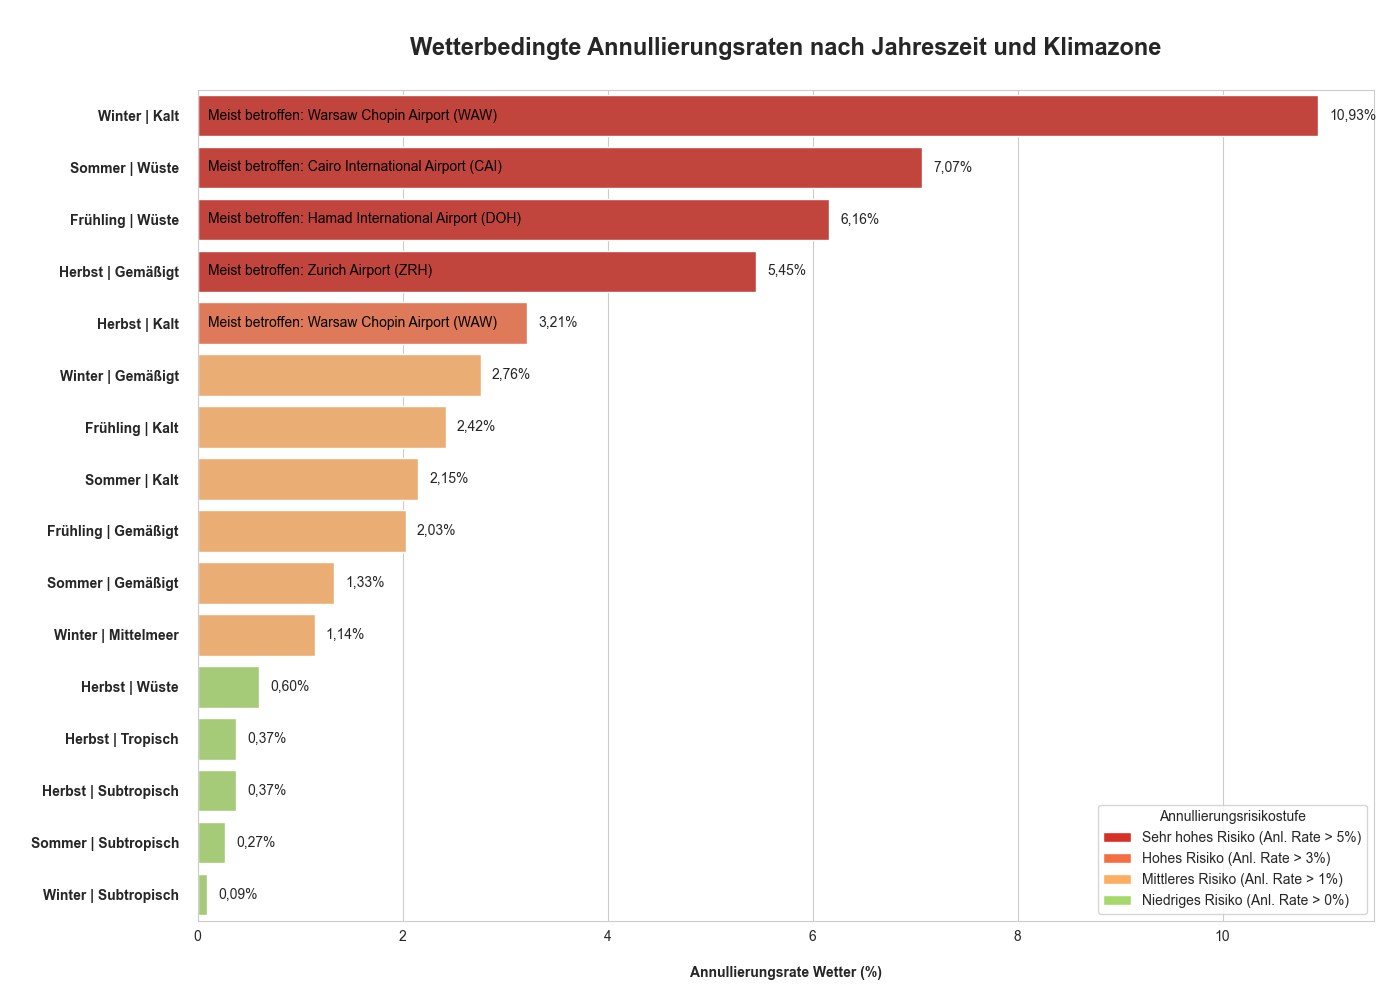

In [117]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

seasons_eng = [
     "Spring", "Summer", "Autumn", "Winter"
]
seasons_ger = [
    "Frühling", "Sommer", "Herbst", "Winter"
]

regions_eng = [
    "Cold", "Desert", "Temperate", "Mediterranean", "Subtropical", "Tropical"
]
regions_ger = [
    "Kalt", "Wüste", "Gemäßigt", "Mittelmeer", "Subtropisch", "Tropisch"
]

df_w_cxl_csa["jahreszeit"] = df_w_cxl_csa["season"].replace(seasons_eng, seasons_ger)
df_w_cxl_csa["klimazone"] = df_w_cxl_csa["airport_climate_region"].replace(regions_eng, regions_ger)

df_w_cxl_csa["jahreszeit_klimazone"] = df_w_cxl_csa["jahreszeit"] + " | " + df_w_cxl_csa["klimazone"]

annotations_english = {
    "title": "\nWeather Cancellation Rates by Season and Climate Region\n",
    "y": "seasonal_airport_climate_region", "x_label": "\nWeather Cancellation Rate (%)",
    "legend_title": "Cancellation Risk Level", "impacted": "Most impacted",
    "file_name": "english/(09)_wcxl_climate_seasons_airports.png"
}

annotations_german = {
    "title": "\nWetterbedingte Annullierungsraten nach Jahreszeit und Klimazone\n",
    "y": "jahreszeit_klimazone", "x_label": "\nAnnullierungsrate Wetter (%)",
    "legend_title": "Annullierungsrisikostufe", "impacted": "Meist betroffen",
    "file_name": "german/(09)_wcxl_klima_jahreszeit_flughafen.png"
}

annot = [annotations_german if language_setting == "German" else annotations_english][0]

# enforce season/climate region order, assign risk category labels, build a custom palette

df_w_cxl_csa["seasonal_airport_climate_region"] = pd.Categorical(
    df_w_cxl_csa["seasonal_airport_climate_region"],
    categories=df_w_cxl_csa["seasonal_airport_climate_region"],
    ordered=True
)

risk_categories = [
    "Very High Risk (Cxl Rate > 5%)", "High Risk (Cxl Rate > 3%)",
    "Moderate Risk (Cxl Rate > 1%)", "Low Risk (Cxl Rate > 0%)"
]

df_w_cxl_csa["cxl_risk_level"] = pd.Categorical(
    df_w_cxl_csa["cxl_risk_level"],
    categories=risk_categories,
    ordered=True
)

risk_palette = {
    "Very High Risk (Cxl Rate > 5%)": "#d73027",   # red
    "High Risk (Cxl Rate > 3%)": "#f46d43",        # reddish-orange
    "Moderate Risk (Cxl Rate > 1%)": "#fdae61",    # strong orange
    "Low Risk (Cxl Rate > 0%)": "#a6d96a",         # greenish-lime
}

risk_cat_display_map_ger = {
    "Very High Risk (Cxl Rate > 5%)": "Sehr hohes Risiko (Anl. Rate > 5%)"
        if language_setting == "German" else "Very High Risk (Cxl Rate > 5%)",
    "High Risk (Cxl Rate > 3%)": "Hohes Risiko (Anl. Rate > 3%)"
        if language_setting == "German" else "High Risk (Cxl Rate > 3%)",
    "Moderate Risk (Cxl Rate > 1%)": "Mittleres Risiko (Anl. Rate > 1%)"
        if language_setting == "German" else "Moderate Risk (Cxl Rate > 1%)",
    "Low Risk (Cxl Rate > 0%)": "Niedriges Risiko (Anl. Rate > 0%)"
        if language_setting == "German" else "Low Risk (Cxl Rate > 0%)"
}

# plot
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=df_w_cxl_csa,
    x="weather_cxl_rate_pct",
    y=annot["y"],
    hue="cxl_risk_level",
    dodge=False,
    palette=risk_palette,
    legend=False
)

# display airport names for highest risk level bars

very_high_risk_df = (
    df_w_cxl_csa.query("cxl_risk_level == 'Very High Risk (Cxl Rate > 5%)' or cxl_risk_level == 'High Risk (Cxl Rate > 3%)'")
)

for bar, (_, row) in zip(ax.patches, very_high_risk_df.iterrows()):
    text = f"{annot["impacted"]}: {row['most_impacted_airport']}"
    bar_x = bar.get_x() + 9.2
    bar_y = bar.get_y()
    bar_width = bar.get_width()
    bar_height = bar.get_height()
    ax.text(
        x=bar_x - 9.1,
        y=bar_y + bar_height / 2,
        s=text,
        va='center',
        ha='left',
        fontsize=10,
        color='black',
        linespacing=1.5
    )

for index, row in df_w_cxl_csa.iterrows():
    plt.text(
        row["weather_cxl_rate_pct"] + 0.11,
        index,
        locale.format_string("%.2f", row["weather_cxl_rate_pct"], grouping=False) + "%",
        va='center',
        ha='left',
        fontsize=10
    )

# title, x and y labels
plt.title(annot["title"], fontsize=17, fontweight="bold")
plt.xlabel(annot["x_label"], fontweight='bold')
plt.ylabel(" ", fontsize=12)

ax.yaxis.set_tick_params(pad=10)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

# legend
legend_elements = [
    Patch(facecolor=color, label=risk_cat_display_map_ger[label])
    for label, color in risk_palette.items()
]
plt.legend(handles=legend_elements, title=annot["legend_title"], loc="lower right")

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

## Customers

In [67]:
with open("../(f)_customers/(01a)_age_group_class_bookings.sql", "r", encoding="utf-8") as file:
    age_class = file.read()

df_age_class = pd.read_sql_query(sql=sql_text(age_class), con=engine)

df_age_class = df_age_class.query("cabin_configuration == '(2) Economy, Business, First'")

df_age_class

,cabin_configuration,age_group,passenger_class,total_bkgs_overall,age_group_bkg_share_overall,age_grp_cl_bookings,age_grp_class_bkg_rate,age_grp_bkg_share_by_cl,cl_bkg_share_by_age_grp
10,"(2) Economy, Business, First",(1) Age <= 24,(1) Economy,12929217,"18,32",257830,"14,14","79,26","19,03"
11,"(2) Economy, Business, First",(1) Age <= 24,(2) Business,12929217,"18,32",52681,"2,89","16,20","14,31"
12,"(2) Economy, Business, First",(1) Age <= 24,(3) First,12929217,"18,32",14774,"0,81","4,54","14,64"
13,"(2) Economy, Business, First",(2) Age 25-34,(1) Economy,12929217,"36,69",509609,"27,94","77,64","37,62"
14,"(2) Economy, Business, First",(2) Age 25-34,(2) Business,12929217,"36,69",113985,"6,25","17,37","30,96"
15,"(2) Economy, Business, First",(2) Age 25-34,(3) First,12929217,"36,69",32812,"1,80","5,00","32,50"
16,"(2) Economy, Business, First",(3) Age 35-44,(1) Economy,12929217,"25,86",352515,"19,33","75,08","26,02"
17,"(2) Economy, Business, First",(3) Age 35-44,(2) Business,12929217,"25,86",91310,"5,01","19,45","24,80"
18,"(2) Economy, Business, First",(3) Age 35-44,(3) First,12929217,"25,86",25719,"1,41","5,48","25,48"
19,"(2) Economy, Business, First",(4) Age 45-60,(1) Economy,12929217,"12,21",154038,"8,45","66,02","11,37"


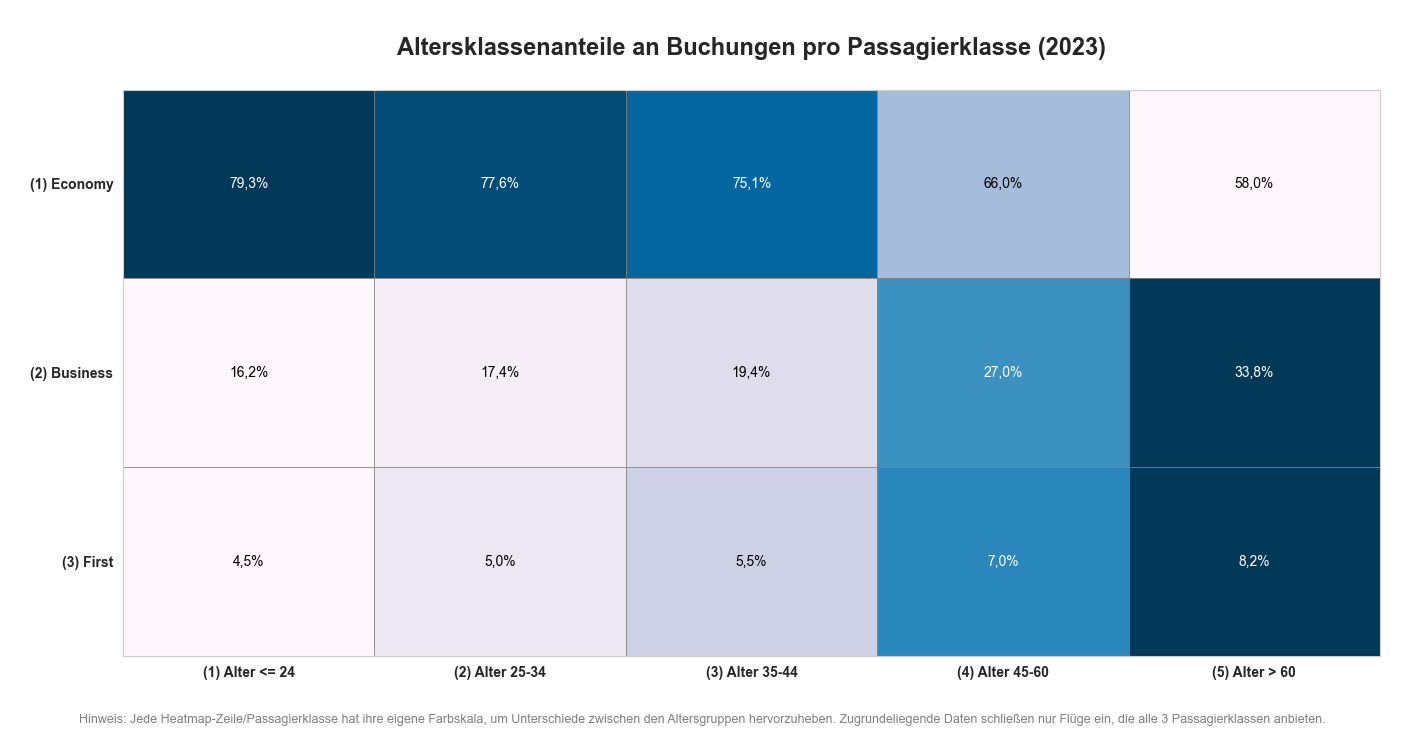

In [68]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

df_age_class["altersgruppe"] = [str(x).replace("Age", "Alter") for x in df_age_class["age_group"]]

annotations_english = {
    "title": "\nAge Group Shares of Bookings by Passenger Class (2023)\n",
    "idx_hm": "passenger_class", "col_hm": "age_group", "file_name": "english/(10)_age_classes_heatmap.png",
    "note": "Note: Each heatmap row/passenger class has it's own color scale to highlight differences "
            "between age groups. Underlying data includes only flights which offer all 3 passenger classes."
}

annotations_german = {
    "title": "\nAltersklassenanteile an Buchungen pro Passagierklasse (2023)\n",
    "idx_hm": "passenger_class", "col_hm": "altersgruppe", "file_name": "german/(10)_alter_klassen_heatmap.png",
    "note": "Hinweis: Jede Heatmap-Zeile/Passagierklasse hat ihre eigene Farbskala, um Unterschiede zwischen "
            "den Altersgruppen hervorzuheben. Zugrundeliegende Daten schließen nur Flüge ein, die alle 3 "
            "Passagierklassen anbieten."
}

annot = [annotations_german if language_setting == "German" else annotations_english][0]

# pivot table for heatmap
data = df_age_class.pivot_table(
    index=annot["idx_hm"], columns=annot["col_hm"], values="age_grp_bkg_share_by_cl"
)

# initialize figure
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor("#C9C9C9")

# custom colormap
cmap = colormaps["PuBu"]

def get_text_color(hex_color):
    r, g, b = m_colors.to_rgb(hex_color)
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return "black" if luminance > 0.6 else "white"

# build a colored matrix manually
for i, (row_idx, row) in enumerate(data.iterrows()):
    # normalize the row to 0–1 range
    norm = Normalize(vmin=row.min(), vmax=row.max())

    for j, (col_idx, val) in enumerate(row.items()):
        if pd.notnull(val):
            color = cmap(norm(val))
            ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='gray', linewidth=0.5))
            ax.text(j + 0.5, i + 0.5, locale.format_string("%.1f", val, grouping=False) + "%",
                    ha='center', va='center', color=get_text_color(color), fontsize=10)

# format axis
ax.set_xticks(np.arange(len(data.columns)) + 0.5)
ax.set_yticks(np.arange(len(data.index)) + 0.5)
ax.set_xticklabels(data.columns, rotation=0, fontweight='bold')
ax.set_yticklabels(data.index, fontweight='bold')

ax.set_xlim(0, len(data.columns))
ax.set_ylim(0, len(data.index))

plt.gca().invert_yaxis()

ax.set_title(annot["title"], fontsize=17, fontweight='bold')
plt.xlabel("")
plt.ylabel(" ")
plt.figtext(1, 0, " ", fontsize=12)

# footnote
plt.figtext(0.505, -0.04, annot["note"], wrap=True, horizontalalignment='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()

In [69]:
with open("../(F)_customers/(02a)_age_group_flyer_stat.sql", "r", encoding="utf-8") as file:
    age_group_flyer_status = file.read()

df_age_group_flyer_status = pd.read_sql_query(sql=sql_text(age_group_flyer_status), con=engine)

df_age_group_flyer_status = df_age_group_flyer_status.copy().query(
    "age_group != '(GRAND TOTAL)' and age_group != '(ALL)' and frq_flyer_status != '(ALL STATUSES)'")

df_age_group_flyer_status

,age_group,frq_flyer_status,total_bookings_overall,total_unique_customers_overall,age_group_uq_cust_share_overall,age_grp_status_bkgs,age_grp_status_bkg_rate,age_grp_uq_cust_share_by_status,status_uq_cust_share_by_age_grp
0,(1) Age <= 24,(0) None,13397158,8548130,"21,11",2003607,"14,96","87,24","34,24"
1,(1) Age <= 24,(1) Basic,13397158,8548130,"21,11",223489,"1,67","7,34","4,47"
2,(1) Age <= 24,(2) Silver,13397158,8548130,"21,11",189785,"1,42","4,65","9,90"
3,(1) Age <= 24,(3) Gold,13397158,8548130,"21,11",39108,"0,29","0,75","9,93"
4,(1) Age <= 24,(4) Platinum,13397158,8548130,"21,11",1219,"0,01","0,02","10,23"
6,(2) Age 25-34,(0) None,13397158,8548130,"38,35",2498070,"18,65","59,73","42,58"
7,(2) Age 25-34,(1) Basic,13397158,8548130,"38,35",2038689,"15,22","35,32","39,08"
8,(2) Age 25-34,(2) Silver,13397158,8548130,"38,35",316553,"2,36","4,25","16,43"
9,(2) Age 25-34,(3) Gold,13397158,8548130,"38,35",64343,"0,48","0,69","16,46"
10,(2) Age 25-34,(4) Platinum,13397158,8548130,"38,35",2011,"0,02","0,02","16,67"


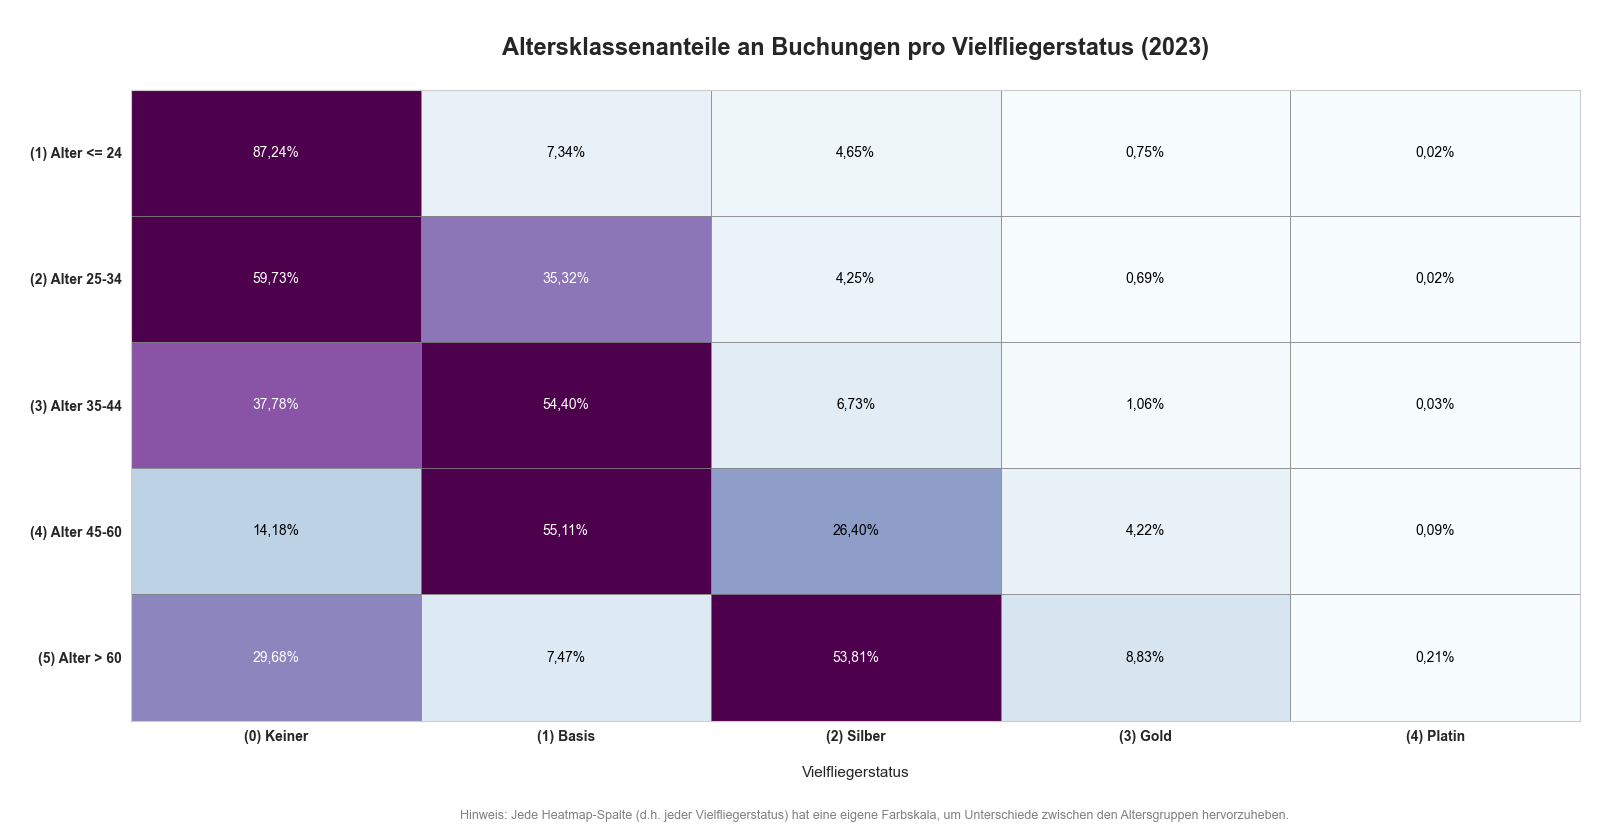

In [70]:
# overwrite global setting, if desired
#language_setting = "German"
#set_display_locale(language_setting)

statuses_eng = ["(0) None", "(1) Basic", "(2) Silver", "(3) Gold", "(4) Platinum"]
statuses_ger = ["(0) Keiner", "(1) Basis", "(2) Silber", "(3) Gold", "(4) Platin"]

df_age_group_flyer_status["vielfliegerstatus"] = df_age_group_flyer_status["frq_flyer_status"].replace(statuses_eng, statuses_ger)
df_age_group_flyer_status["altersgruppe"] = [str(x).replace("Age", "Alter") for x in df_age_group_flyer_status["age_group"]]

annotations_english = {
    "title": "\nAge Group Shares of Bookings by Frequent Flyer Status (2023)\n", "x_label": "\nFrequent Flyer Status",
    "idx_hm": "age_group", "col_hm": "frq_flyer_status", "file_name": "english/(11)_age_frq_flyer_heatmap.png",
    "note": "Note: Each heatmap column/frequent flyer status has it's own color scale "
            "to highlight differences between age groups."
}

annotations_german = {
    "title": "\nAltersklassenanteile an Buchungen pro Vielfliegerstatus (2023)\n", "x_label": "\nVielfliegerstatus",
    "idx_hm": "altersgruppe", "col_hm": "vielfliegerstatus", "file_name": "german/(11)_alter_vielflieger_heatmap.png",
    "note": "Hinweis: Jede Heatmap-Spalte (d.h. jeder Vielfliegerstatus) hat eine eigene Farbskala, "
            "um Unterschiede zwischen den Altersgruppen hervorzuheben."
}

annot = [annotations_german if language_setting == "German" else annotations_english][0]

# pivot table
data = df_age_group_flyer_status.pivot_table(
    index=annot["idx_hm"], columns=annot["col_hm"], values="age_grp_uq_cust_share_by_status"
)

# initialize figure
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_facecolor("#C9C9C9")

# custom colormap
cmap = colormaps["BuPu"]

def get_text_color(hex_color):
    r, g, b = m_colors.to_rgb(hex_color)
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return "black" if luminance > 0.6 else "white"

# build a colored matrix manually
for i, (row_idx, row) in enumerate(data.iterrows()):
    # normalize the row to 0–1 range
    norm = Normalize(vmin=row.min(), vmax=row.max())

    for j, (col_idx, val) in enumerate(row.items()):
        if pd.notnull(val):
            color = cmap(norm(val))
            ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='gray', linewidth=0.5))
            ax.text(j + 0.5, i + 0.5, locale.format_string("%.2f", val, grouping=False) + "%",
                    ha='center', va='center', color=get_text_color(color), fontsize=10)

# format axis
ax.set_xticks(np.arange(len(data.columns)) + 0.5)
ax.set_yticks(np.arange(len(data.index)) + 0.5)
ax.set_xticklabels(data.columns, rotation=0, fontweight='bold')
ax.set_yticklabels(data.index, fontweight='bold')

ax.set_xlim(0, len(data.columns))
ax.set_ylim(0, len(data.index))

plt.gca().invert_yaxis()

ax.set_title(annot["title"], fontsize=17, fontweight='bold')
plt.xlabel(annot["x_label"], fontsize=11)
plt.ylabel(" ")
plt.figtext(1, 0, " ", fontsize=12)

# footnote
plt.figtext(0.55, -0.03, annot["note"], wrap=True, horizontalalignment='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig(annot["file_name"], dpi=300, bbox_inches="tight")
plt.show()